# Ghidra_bench study

In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json
import os
import numpy as np
import matplotlib.lines as mlines
from scipy import stats

## Dependencies and dataset

In [115]:
# Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

LOGS_PATH = './llm_server/logs/llm_metrics.csv'
REPORTS_PATH = './ghidra_bench/outputs/reports/*.json'

In [116]:
def load_metrics(path):
    try:
        df = pd.read_csv(path)     
        df = df.drop(columns=df.columns[:2])
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return pd.DataFrame()

    return df

df_metrics = load_metrics(LOGS_PATH)

print(f"Loaded {len(df_metrics)} hardware metric records.")
df_metrics.head()

# remove the entries with exactly 2048 generated tokens
df_metrics = df_metrics[df_metrics['generated_tokens'] != 2048]

#remove when model_id is qwen-2.5
df_metrics = df_metrics[df_metrics['model_id'] != 'qwen-2.5']

#remove operation token_loss
df_metrics = df_metrics[df_metrics['operation'] != 'analyze_token_loss']

Loaded 17527 hardware metric records.


# LLM

## Time LLM study

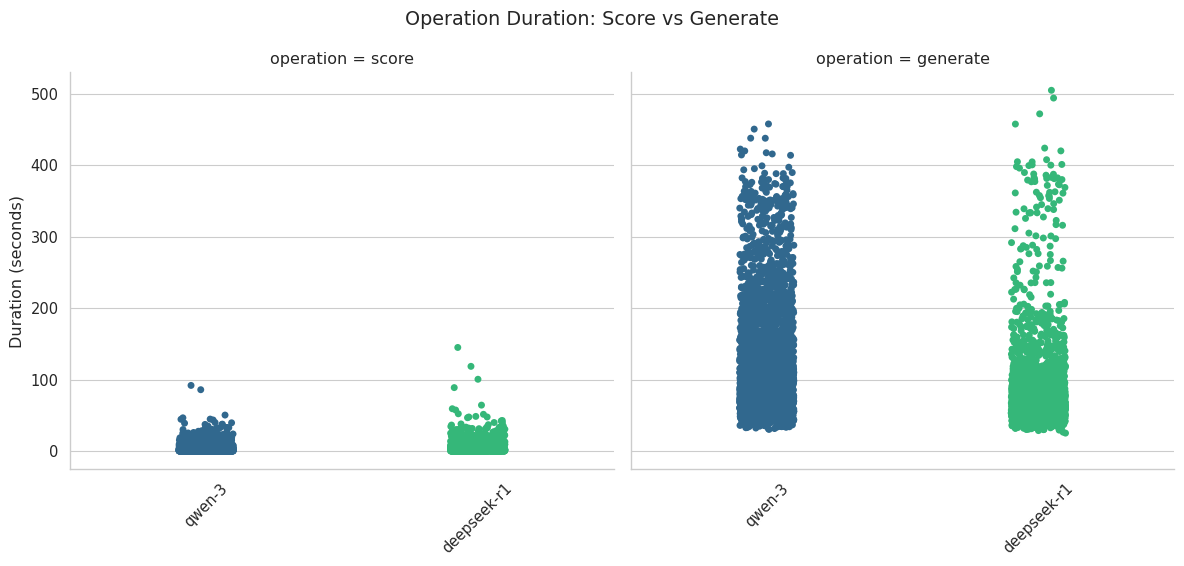

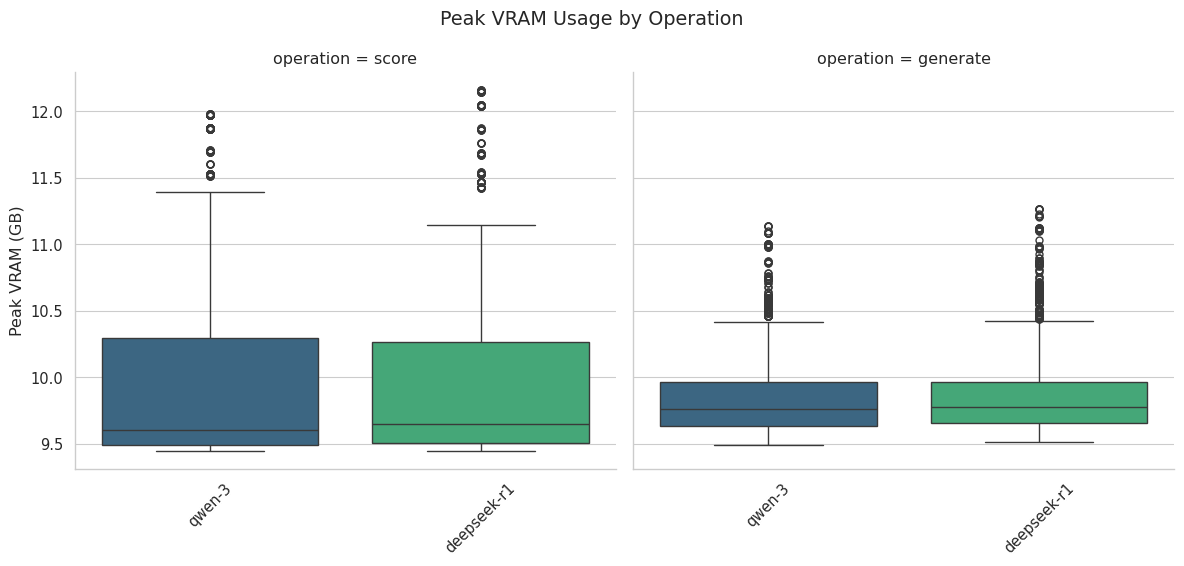

In [117]:
if not df_metrics.empty:
    g = sns.catplot(
        data=df_metrics, 
        x='model_id', 
        y='duration_sec', 
        col='operation',  # split for 'score' and 'generate'
        kind='strip', #'box',
        hue='model_id', 
        palette='viridis', 
        height=5, 
        aspect=1.2,
        #sharey=False      # Independent Y-axis
    )
    g.figure.suptitle('Operation Duration: Score vs Generate', y=1.05)
    g.set_axis_labels("", "Duration (seconds)")
    g.set_xticklabels(rotation=45)
    
    g_vram = sns.catplot(
        data=df_metrics, 
        x='model_id', 
        y='peak_vram_gb',
        col='operation',
        kind='box', 
        hue='model_id', 
        palette='viridis', 
        height=5, 
        aspect=1.2
    )
    g_vram.figure.suptitle('Peak VRAM Usage by Operation', y=1.05)
    g_vram.set_axis_labels("", "Peak VRAM (GB)")
    g_vram.set_xticklabels(rotation=45)
    # for ax in g_vram.axes.flat:
    #     ax.axhline(16, color='red', linestyle='--', linewidth=2, label='Limit VRAM')
        

    plt.show()
else:
    print("No metrics data found.")

## Generation study

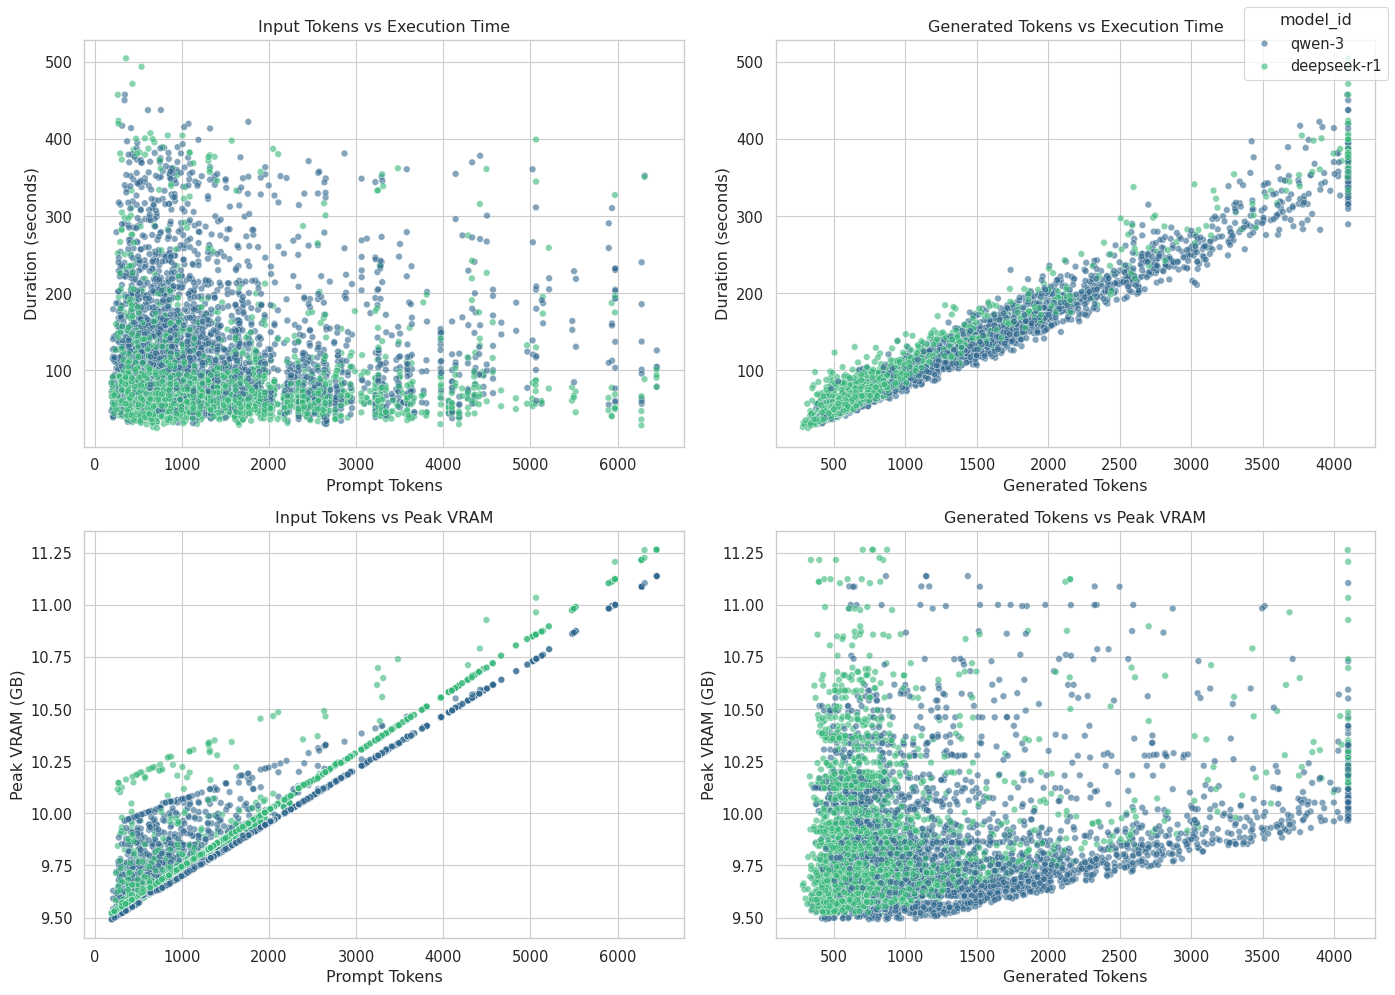

In [118]:
df_gen = df_metrics[df_metrics['operation'] == 'generate'].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(data=df_gen, x='prompt_tokens', y='duration_sec', hue='model_id', palette='viridis', alpha=0.6, ax=axes[0, 0])
axes[0, 0].set_title('Input Tokens vs Execution Time')
axes[0, 0].set_xlabel('Prompt Tokens')
axes[0, 0].set_ylabel('Duration (seconds)')

sns.scatterplot(data=df_gen, x='generated_tokens', y='duration_sec', hue='model_id', palette='viridis', alpha=0.6, ax=axes[0, 1])
axes[0, 1].set_title('Generated Tokens vs Execution Time')
axes[0, 1].set_xlabel('Generated Tokens')
axes[0, 1].set_ylabel('Duration (seconds)')

sns.scatterplot(data=df_gen, x='prompt_tokens', y='peak_vram_gb', hue='model_id', palette='viridis', alpha=0.6, ax=axes[1, 0])
axes[1, 0].set_title('Input Tokens vs Peak VRAM')
axes[1, 0].set_xlabel('Prompt Tokens')
axes[1, 0].set_ylabel('Peak VRAM (GB)')

sns.scatterplot(data=df_gen, x='generated_tokens', y='peak_vram_gb', hue='model_id', palette='viridis', alpha=0.6, ax=axes[1, 1])
axes[1, 1].set_title('Generated Tokens vs Peak VRAM')
axes[1, 1].set_xlabel('Generated Tokens')
axes[1, 1].set_ylabel('Peak VRAM (GB)')

for ax in axes.flat:
    ax.get_legend().remove()
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title='model_id', loc='upper right')

plt.tight_layout()
plt.show()


## Score study

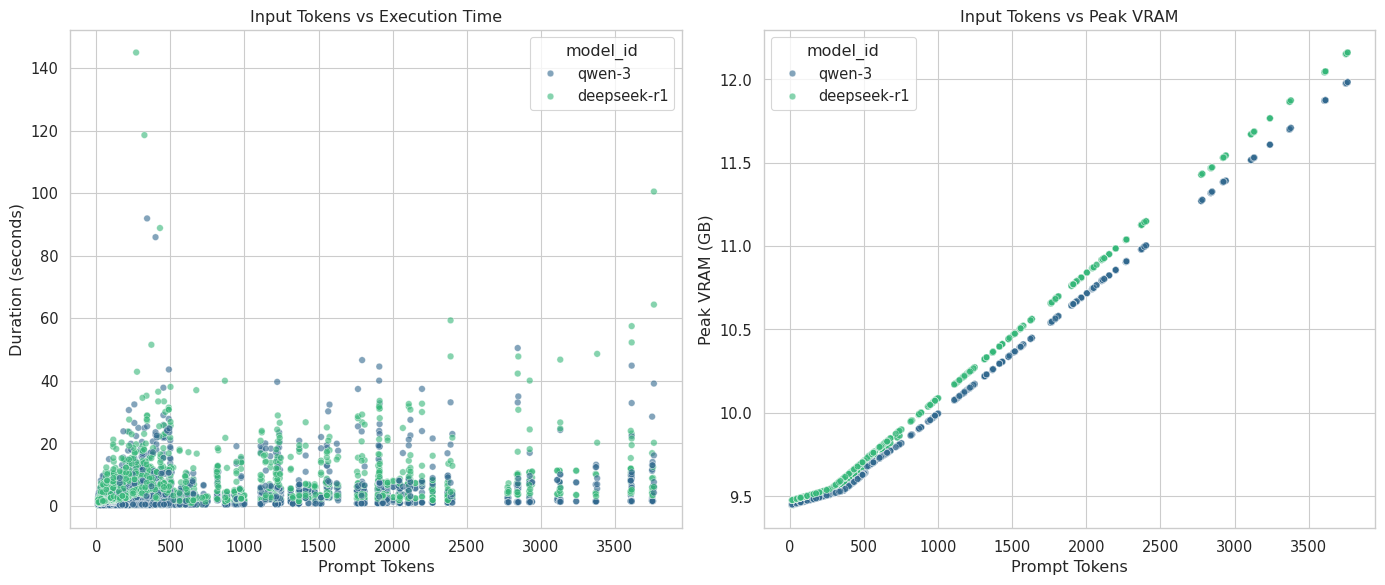

In [119]:
df_gen = df_metrics[df_metrics['operation'] == 'score'].copy()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='duration_sec', hue='model_id', palette='viridis', alpha=0.6)
plt.title('Input Tokens vs Execution Time')
plt.xlabel('Prompt Tokens')
plt.ylabel('Duration (seconds)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='peak_vram_gb', hue='model_id', palette='viridis', alpha=0.6)
plt.title('Input Tokens vs Peak VRAM')
plt.xlabel('Prompt Tokens')
plt.ylabel('Peak VRAM (GB)')


plt.tight_layout()
plt.show()

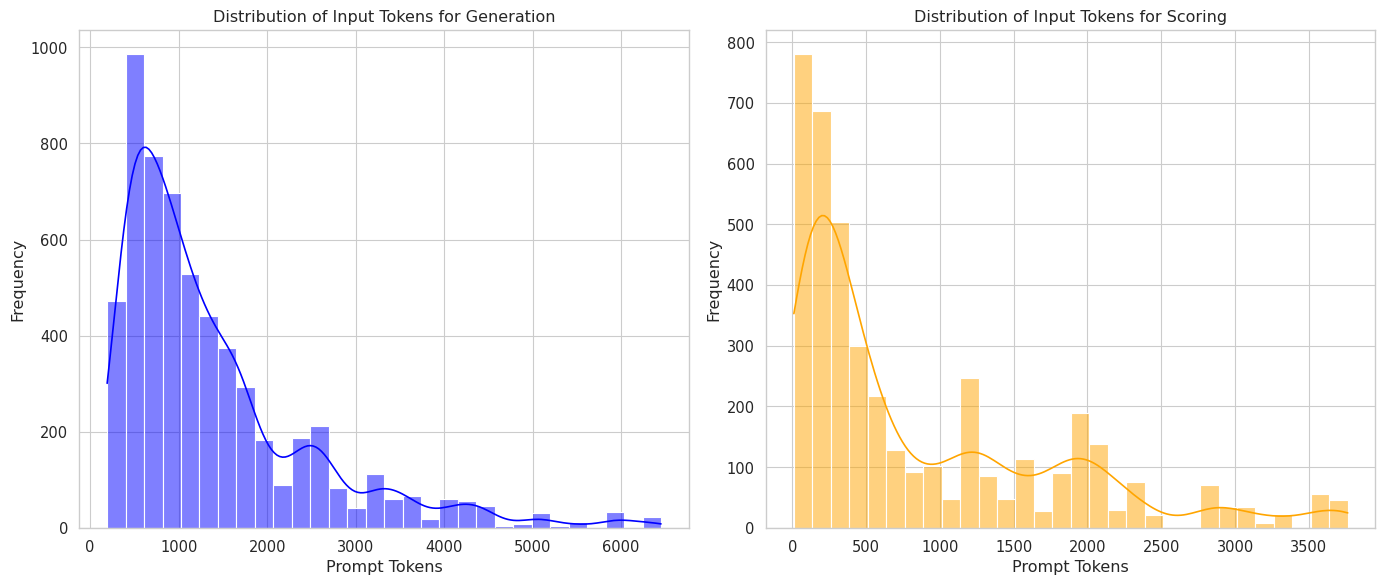

In [120]:
#distribution token input generation vs score
df_gen = df_metrics[df_metrics['operation'] == 'generate'].copy()
df_score = df_metrics[df_metrics['operation'] == 'score'].copy()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df_gen, x='prompt_tokens', bins=30, kde=True, color='blue')
plt.title('Distribution of Input Tokens for Generation')
plt.xlabel('Prompt Tokens')
plt.ylabel('Frequency') 

plt.subplot(1, 2, 2)
sns.histplot(data=df_score, x='prompt_tokens', bins=30, kde=True, color='orange')
plt.title('Distribution of Input Tokens for Scoring')
plt.xlabel('Prompt Tokens')
plt.ylabel('Frequency') 
plt.tight_layout()
plt.show()

# Reports study

### Generation humanity

In [121]:
import re

def load_reports(path_pattern):
    all_records = []
    files = glob.glob(path_pattern)
    
    print(f"Found {len(files)} report files.")
    
    for f_path in files:
        try:
            with open(f_path, 'r') as f:
                data = json.load(f)
            
            pr_number = data.get('pr', 'unknown')
            
            results_dict = data.get('results', {})
            
            for model_id, items in results_dict.items():
                for item in items:
                    metrics = item.get('metrics', {})

                    def get_metric(metrics, key):
                        value = metrics.get(key, -1)
                        return value if value != -1 else np.nan
                    
                    ppl_keys = ['base_ppl', 'pr_ppl', 'source_ppl', 'delta_ppl', 'base_ast_ppl', 'pr_ast_ppl', 'source_ast_ppl']
                    for key in ppl_keys:
                        metrics[key] = get_metric(metrics, key)

                    llm_qualitative = item.get('llm_qualitative', {})
                    if 'error' in llm_qualitative:
                        qual_winner = 'Error'
                    else:
                        qual_winner = llm_qualitative.get('winner')
                        if qual_winner == 'Error':
                                qual_winner = 'Error'#continue
            
                    llm_qualitative_source = item.get('llm_qualitative_source', {})
                    if 'error' in llm_qualitative_source:
                        qual_s_winner = 'Error'
                    else:
                        qual_s_winner = llm_qualitative_source.get('winner')
                        if qual_s_winner == 'Error':
                                qual_s_winner = 'Error'#continue
                        
                    llm_ast_qualitative = item.get('llm_ast', {})
                    if 'error' in llm_ast_qualitative:
                        qual_ast_winner = 'Error'
                    else:
                        qual_ast_winner = llm_ast_qualitative.get('winner')
                        if qual_ast_winner == 'Error':
                                qual_ast_winner = 'Error'#continue
                    
                    llm_ast_s_qualitative = item.get('llm_ast_source', {})
                    if 'error' in llm_ast_s_qualitative:
                        qual_ast_s_winner = 'Error'
                    else:
                        qual_ast_s_winner = llm_ast_s_qualitative.get('winner')
                        if qual_ast_s_winner == 'Error':
                                qual_ast_s_winner = 'Error'#continue

                    source_len = len(item.get('source_code', ''))
                    base_len = len(item.get('function_base', ''))
                    pr_len = len(item.get('function_pr', ''))

                    source_ast = item.get('source_ast', '')
                    base_ast = item.get('base_ast', '')
                    pr_ast = item.get('pr_ast', '')
                    
                    record = {
                        'pr': pr_number,
                        'model': model_id,
                        'binary': item.get('binary'),
                        'function': item.get('function'),
                        'source_ast': source_ast,
                        'base_ast': base_ast,
                        'pr_ast': pr_ast,
                        'source_code': item.get('source_code', ''),
                        'function_base': item.get('function_base', ''),
                        'function_pr': item.get('function_pr', ''),
                        # Quantitative Metrics
                        'base_ppl': metrics.get('base_ppl', np.nan),
                        'pr_ppl': metrics.get('pr_ppl', np.nan),
                        'delta_ppl': metrics.get('delta_ppl', np.nan),
                        'source_ppl': metrics.get('source_ppl', np.nan),
                        'ast_base_ppl': metrics.get('base_ast_ppl', np.nan),
                        'ast_pr_ppl': metrics.get('pr_ast_ppl', np.nan),
                        'ast_source_ppl': metrics.get('source_ast_ppl', np.nan),
                        'ast_delta_ppl': metrics.get('pr_ast_ppl', np.nan) - metrics.get('base_ast_ppl', np.nan) if not np.isnan(metrics.get('base_ast_ppl', np.nan)) and not np.isnan(metrics.get('pr_ast_ppl', np.nan)) else np.nan,

                        'source_loss': metrics.get('source_loss', {"tokens": [],"losses": []}),
                        'base_loss': metrics.get('function_base_loss', {"tokens": [],"losses": []}),
                        'pr_loss': metrics.get('function_pr_loss', {"tokens": [],"losses": []}),
                        'source_ast_loss': metrics.get('source_ast_loss', {"tokens": [],"losses": []}),
                        'base_ast_loss': metrics.get('base_ast_loss', {"tokens": [],"losses": []}),
                        'pr_ast_loss': metrics.get('pr_ast_loss', {"tokens": [],"losses": []}),
                        
                        # Qualitative Metrics
                        'qualitative_winner': qual_winner,
                        'qualitative_winner_s': qual_s_winner,
                        'qualitative_ast_winner': qual_ast_winner,
                        'qualitative_ast_winner_s': qual_ast_s_winner,
                        'source_len': source_len,
                        'len_change': pr_len - base_len,
                        'ast_source_len': len(source_ast),
                        'ast_base_len': len(base_ast),
                        'ast_pr_len': len(pr_ast),
                        'ast_len_change': len(pr_ast) - len(base_ast),
                        'is_improvement': metrics.get('delta_ppl', np.nan) < 0
                    }
                    all_records.append(record)
                    
        except Exception as e:
            print(f"Error loading {f_path}: {e}")

    df = pd.DataFrame(all_records)
    return df

df_reports = load_reports(REPORTS_PATH)
print(f"Loaded {len(df_reports)} valid records after filtering errors.")
df_reports.head()

Found 5 report files.
Loaded 214 valid records after filtering errors.


pr   model                               binary           function  \
0  7253  qwen-3  task-libxls_xls_parseWorkBook-O2.so  xls_parseWorkBook   
1  7253  qwen-3  task-libxls_xls_parseWorkBook-O3.so  xls_parseWorkBook   
2  7253  qwen-3      task-file_file_signextend-O0.so    file_signextend   
3  7253  qwen-3      task-file_file_signextend-O2.so    file_signextend   
4  7253  qwen-3      task-file_file_signextend-O3.so    file_signextend   

                                          source_ast  \
0  type id(type *id){\n  if(!id)return id;\n  typ...   
1  type id(type *id){\n  if(!id)return id;\n  typ...   
2  type id(type *id, type *id, type id){\n  if(!(...   
3  type id(type *id, type *id, type id){\n  if(!(...   
4  type id(type *id, type *id, type id){\n  if(!(...   

                                            base_ast  \
0  type id( *id){\n  type id;\n  type id;\n  type...   
1  type id( *id){\n  type id;\n  type id;\n  type...   
2   id( id, type *id,  id){\n  type id;\n  id = i...   
3   id( id, type *id,  id){\n  if((*id & 8) == 0)...   
4   id( id, type *id,  id){\n  if((*id & 8) == 0)...   

                                              pr_ast  \
0  type id( *id){\n  type id;\n  type id;\n  type...   
1  type id( *id){\n  type id;\n  type id;\n  type...   
2   id( id, type *id,  id){\n  type id;\n  id = i...   
3   id( id, type *id,  id){\n  if((*id & 8) == 0)...   
4   id( id, type *id,  id){\n  if((*id & 8) == 0)...   

                                         source_code  \
0  xls_error_t xls_parseWorkBook(xlsWorkBook* pWB...   
1  xls_error_t xls_parseWorkBook(xlsWorkBook* pWB...   
2  file_protected uint64_t\nfile_signextend(struc...   
3  file_protected uint64_t\nfile_signextend(struc...   
4  file_protected uint64_t\nfile_signextend(struc...   

                                       function_base  \
0  \nint xls_parseWorkBook(long *param_1)\n\n{\n ...   
1  \nint xls_parseWorkBook(long *param_1)\n\n{\n ...   
2  \nlong file_signextend(long param_1,ushort *pa...   
3  \nlong file_signextend(long param_1,byte *para...   
4  \nlong file_signextend(long param_1,byte *para...   

                                         function_pr  ...  \
0  \nint xls_parseWorkBook(long *param_1)\n\n{\n ...  ...   
1  \nint xls_parseWorkBook(long *param_1)\n\n{\n ...  ...   
2  \nlong file_signextend(long param_1,ushort *pa...  ...   
3  \nlong file_signextend(long param_1,byte *para...  ...   
4  \nlong file_signextend(long param_1,byte *para...  ...   

   qualitative_winner_s  qualitative_ast_winner  qualitative_ast_winner_s  \
0                   TIE                     TIE                        PR   
1                   TIE                     TIE                        PR   
2                 Error                      PR                     Error   
3                  BASE                     TIE                     Error   
4                   TIE                     TIE                      BASE   

   source_len  len_change  ast_source_len  ast_base_len  ast_pr_len  \
0        6867          27            4587          7436        7461   
1        6867          27            4587          7436        7461   
2        1783           0            1227          1321        1321   
3        1783           0            1227          1268        1268   
4        1783           0            1227          1268        1268   

  ast_len_change is_improvement  
0             25          False  
1             25          False  
2              0          False  
3              0          False  
4              0          False  

[5 rows x 35 columns]

## Perplexity

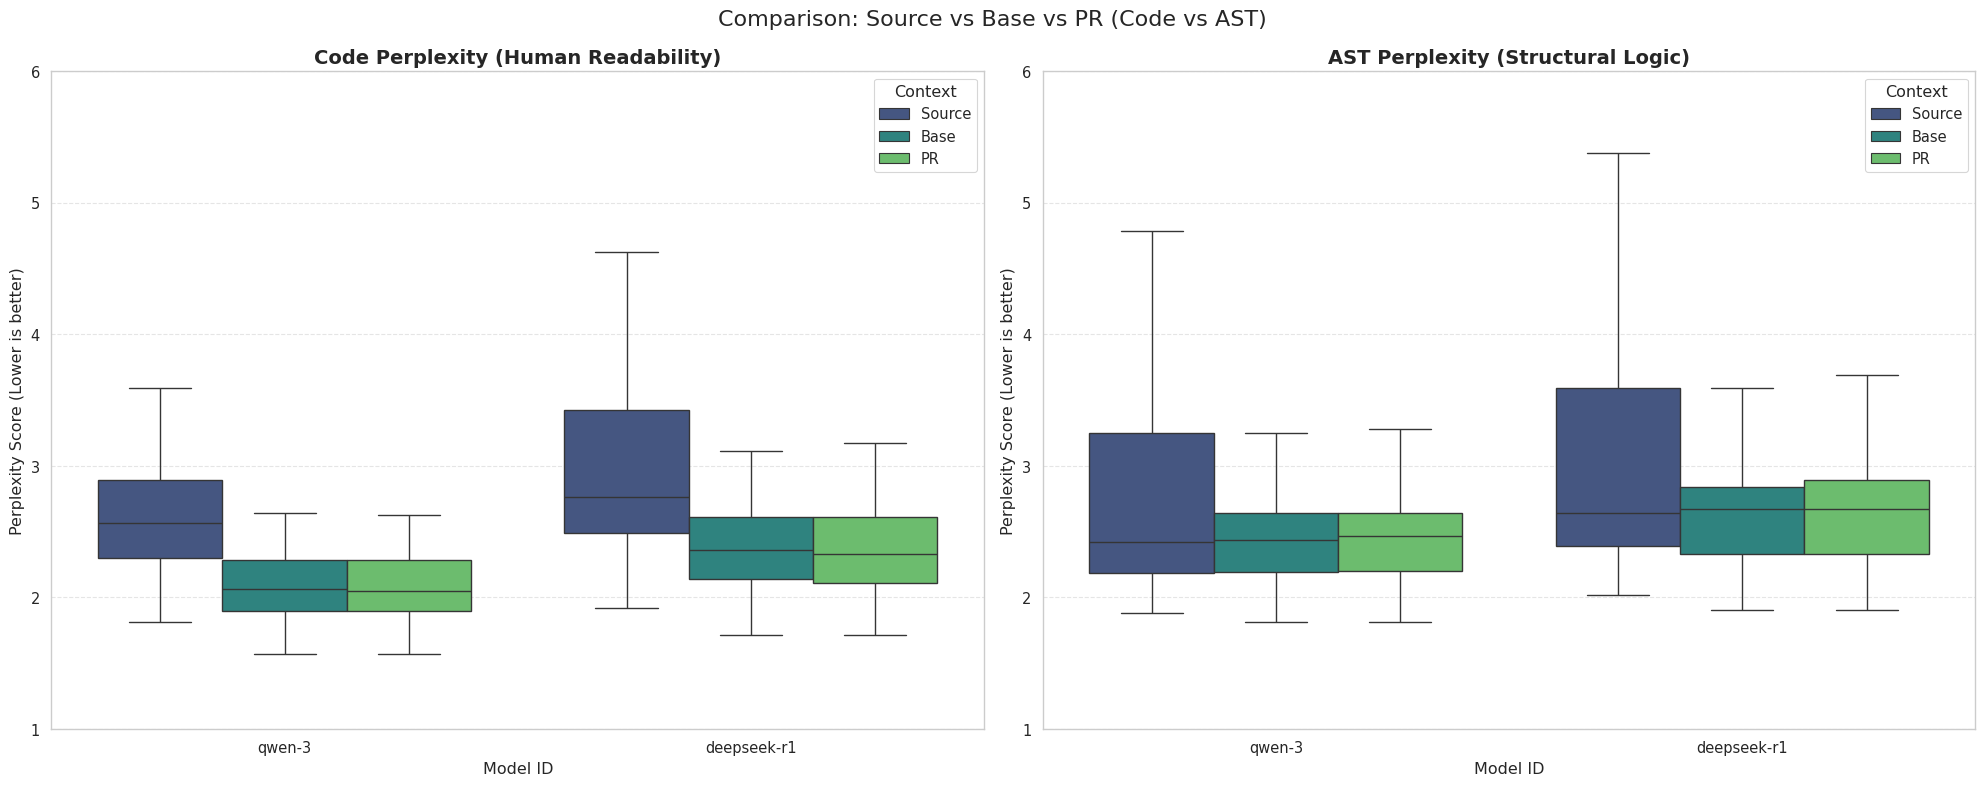

In [122]:
if not df_reports.empty:
    df_code = df_reports.melt(
        id_vars=['model'], 
        value_vars=['source_ppl', 'base_ppl', 'pr_ppl'],
        var_name='metric_type', 
        value_name='perplexity'
    )

    df_code['metric_type'] = df_code['metric_type'].replace({
        'source_ppl': 'Source', 'base_ppl': 'Base', 'pr_ppl': 'PR'
    })

    df_ast = df_reports.melt(
        id_vars=['model'], 
        value_vars=['ast_source_ppl', 'ast_base_ppl', 'ast_pr_ppl'],
        var_name='metric_type', 
        value_name='perplexity'
    )
    df_ast['metric_type'] = df_ast['metric_type'].replace({
        'ast_source_ppl': 'Source', 'ast_base_ppl': 'Base', 'ast_pr_ppl': 'PR'
    })

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)
    
    sns.boxplot(
        data=df_code, 
        x='model', 
        y='perplexity', 
        hue='metric_type', 
        showfliers=False,
        palette='viridis',
        ax=axes[0]
    )
    axes[0].set_title('Code Perplexity (Human Readability)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Perplexity Score (Lower is better)')
    axes[0].set_xlabel('Model ID')
    axes[0].set_ylim(1, 6)
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)
    axes[0].legend(title='Context')

    sns.boxplot(
        data=df_ast, 
        x='model', 
        y='perplexity', 
        hue='metric_type',
        showfliers=False,
        palette='viridis',
        ax=axes[1]
    )
    axes[1].set_title('AST Perplexity (Structural Logic)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Perplexity Score (Lower is better)')
    axes[1].set_xlabel('Model ID')
    axes[1].set_ylim(1, 6)
    axes[1].grid(axis='y', linestyle='--', alpha=0.5)
    axes[1].legend(title='Context')

    plt.suptitle('Comparison: Source vs Base vs PR (Code vs AST)', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame is empty, no plots to generate.")

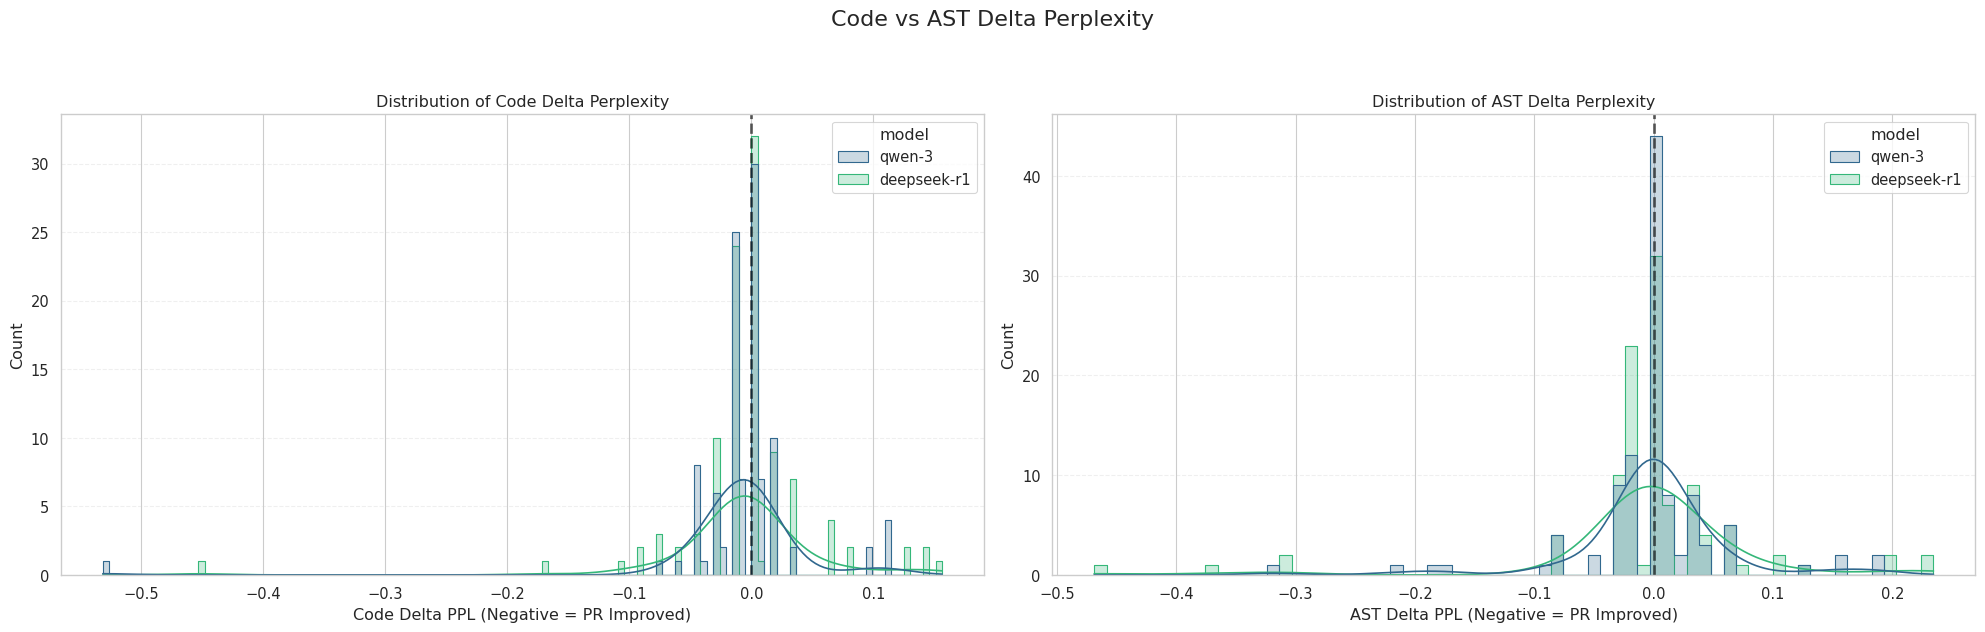

In [123]:
if not df_reports.empty:

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    sns.histplot(
        data=df_reports, 
        x='delta_ppl', 
        hue='model', 
        kde=True, 
        element="step", 
        palette='viridis',
        ax=axes[0]
    )
    axes[0].set_title('Distribution of Code Delta Perplexity')
    axes[0].set_xlabel('Code Delta PPL (Negative = PR Improved)')
    axes[0].axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.6, label='No Change')
    axes[0].grid(axis='y', linestyle='--', alpha=0.3)
    
    df_ast_valid = df_reports.dropna(subset=['ast_delta_ppl'])
    
    has_variance = not df_ast_valid.empty and not (df_ast_valid['ast_delta_ppl'] == 0).all()
    
    if has_variance:
        group_vars = df_ast_valid.groupby('model')['ast_delta_ppl'].var()
        is_singular = (group_vars.fillna(0) == 0).any()
        
        sns.histplot(
            data=df_ast_valid, 
            x='ast_delta_ppl', 
            hue='model', 
            kde=not is_singular,
            element="step", 
            palette='viridis',
            ax=axes[1]
        )
        axes[1].set_title('Distribution of AST Delta Perplexity')
        axes[1].set_xlabel('AST Delta PPL (Negative = PR Improved)')
        axes[1].axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.6, label='No Change')
        axes[1].grid(axis='y', linestyle='--', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, "No Variance / No Data for AST Delta", 
                     ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
        axes[1].set_title('Distribution of AST Delta Perplexity (Singular)')

    plt.suptitle('Code vs AST Delta Perplexity', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

### Perplexity trough PRs

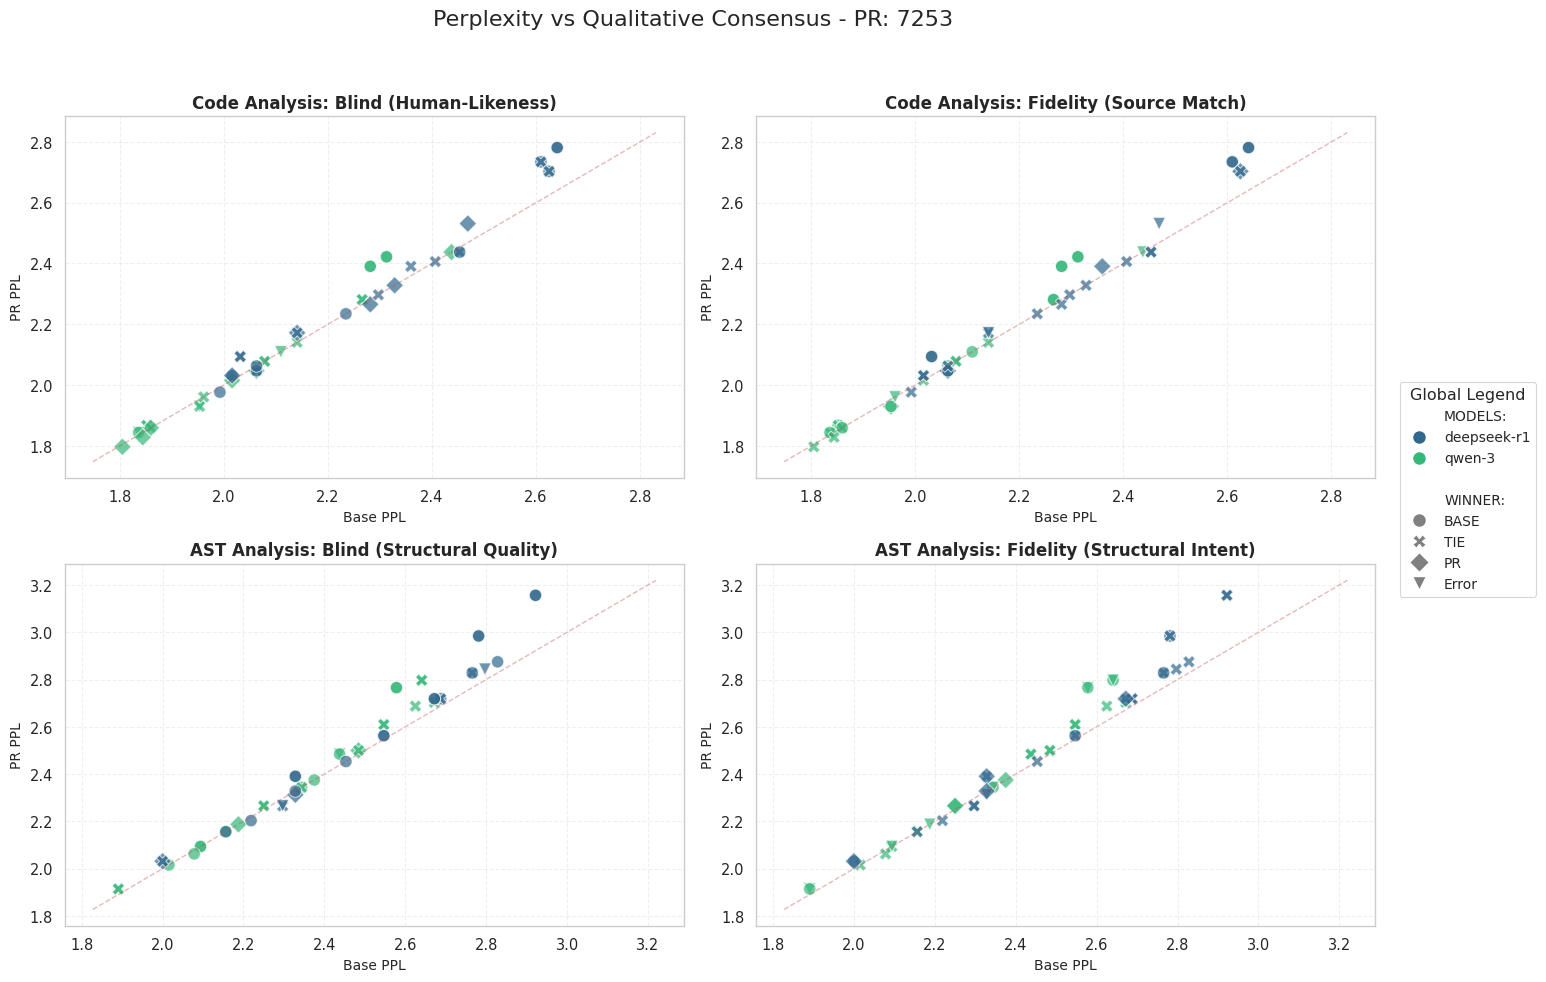

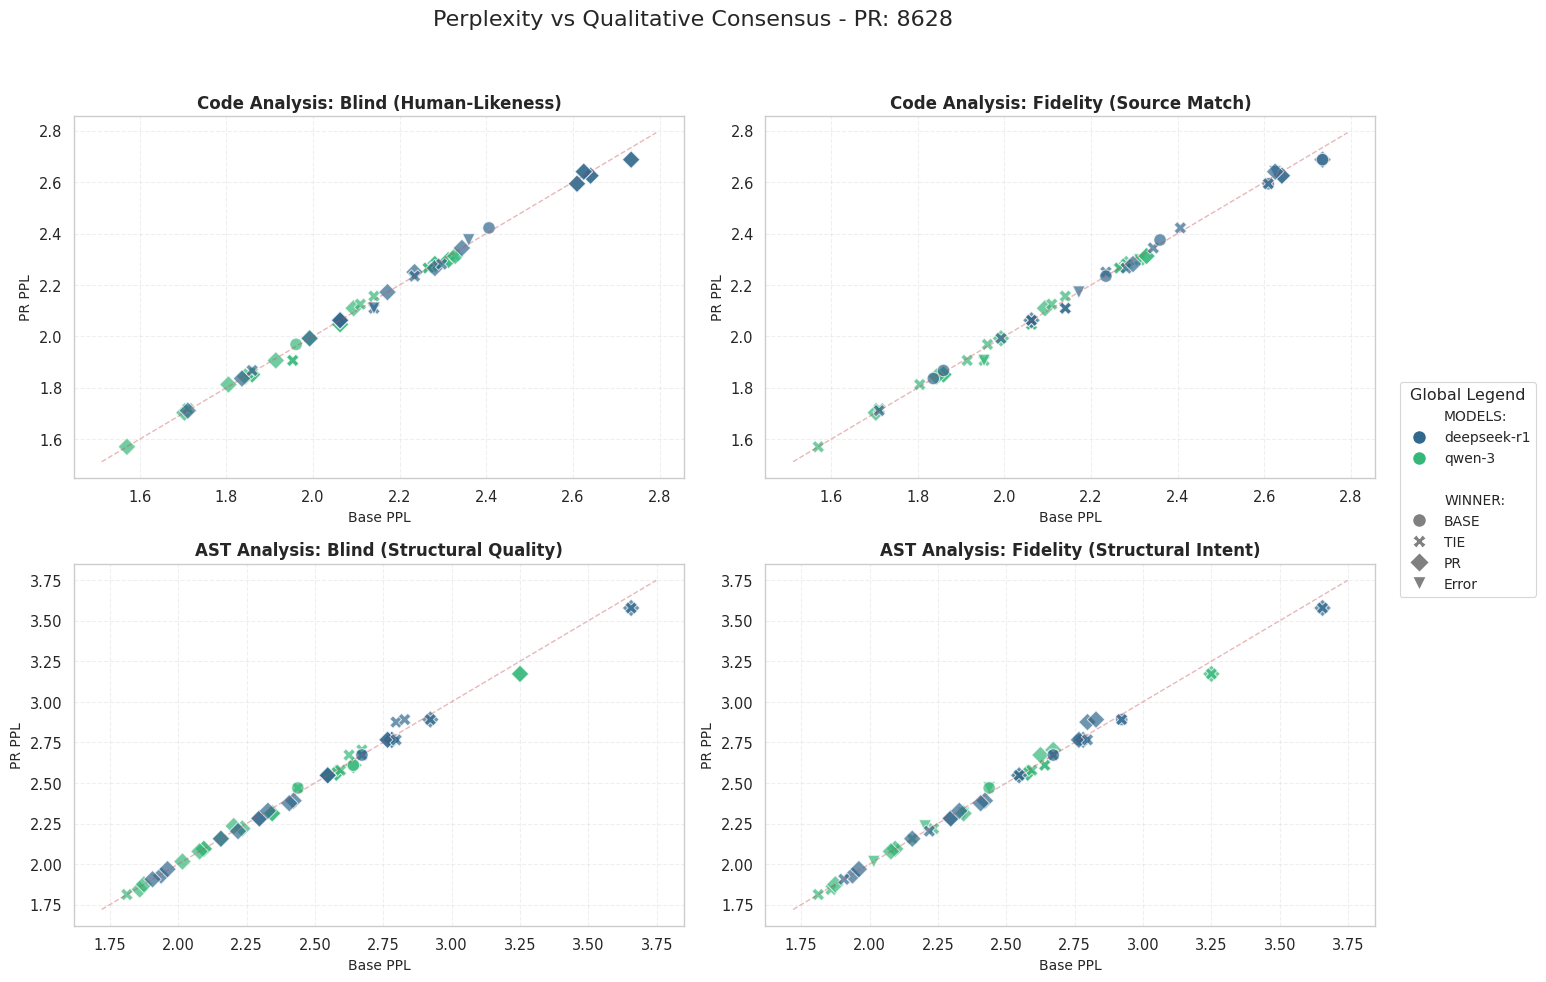

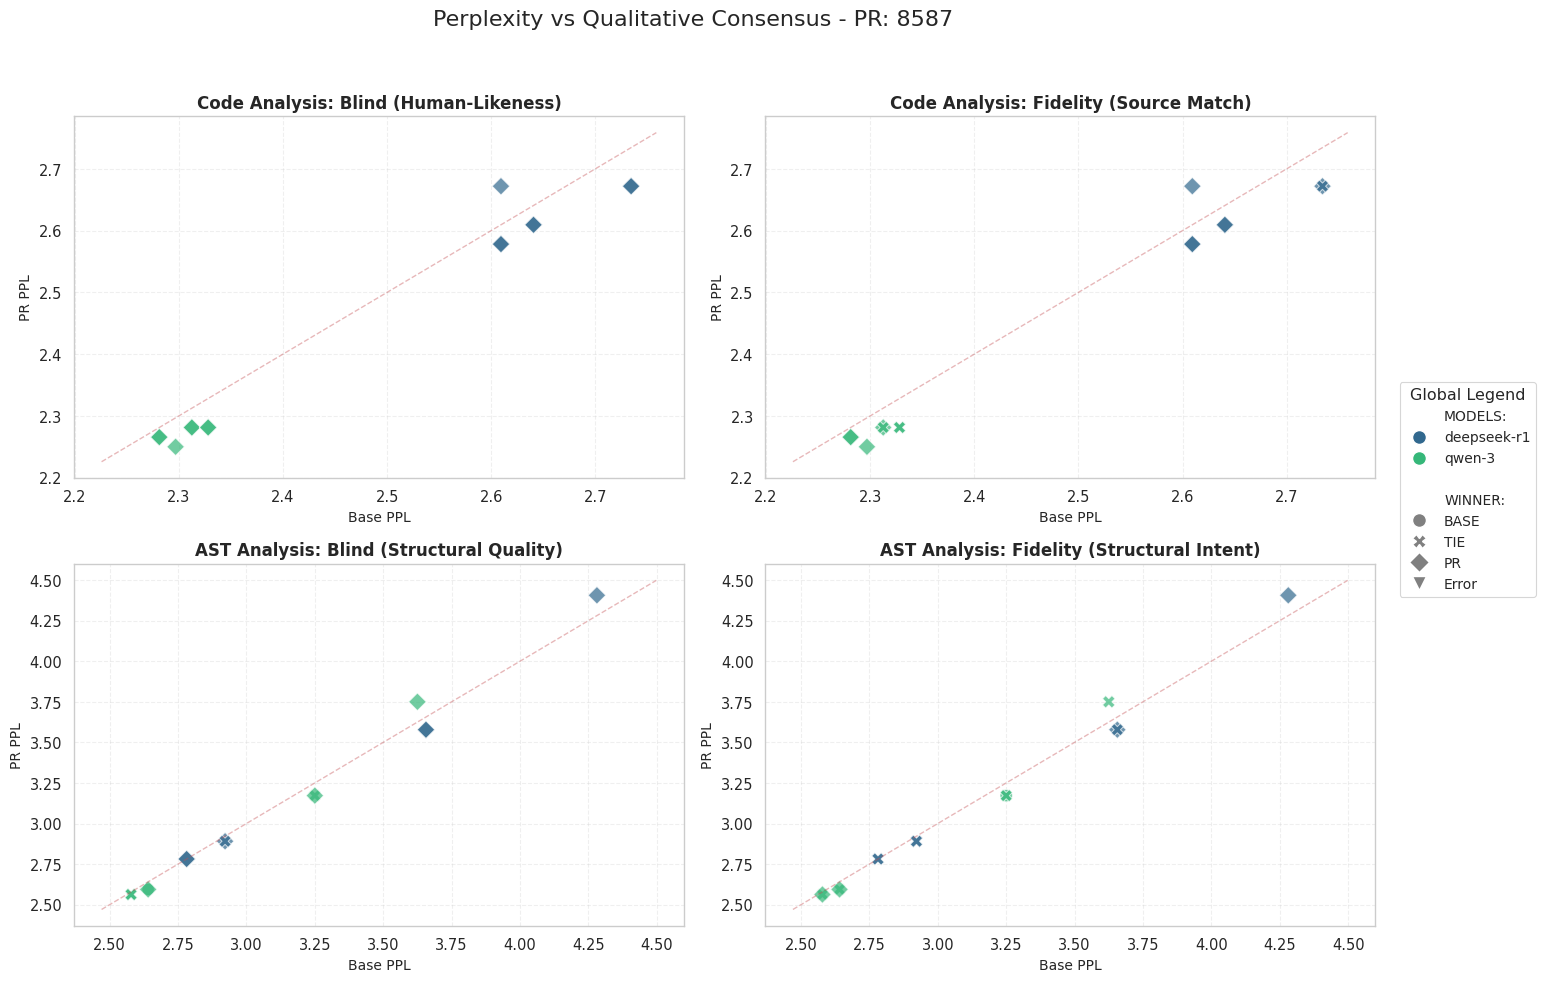

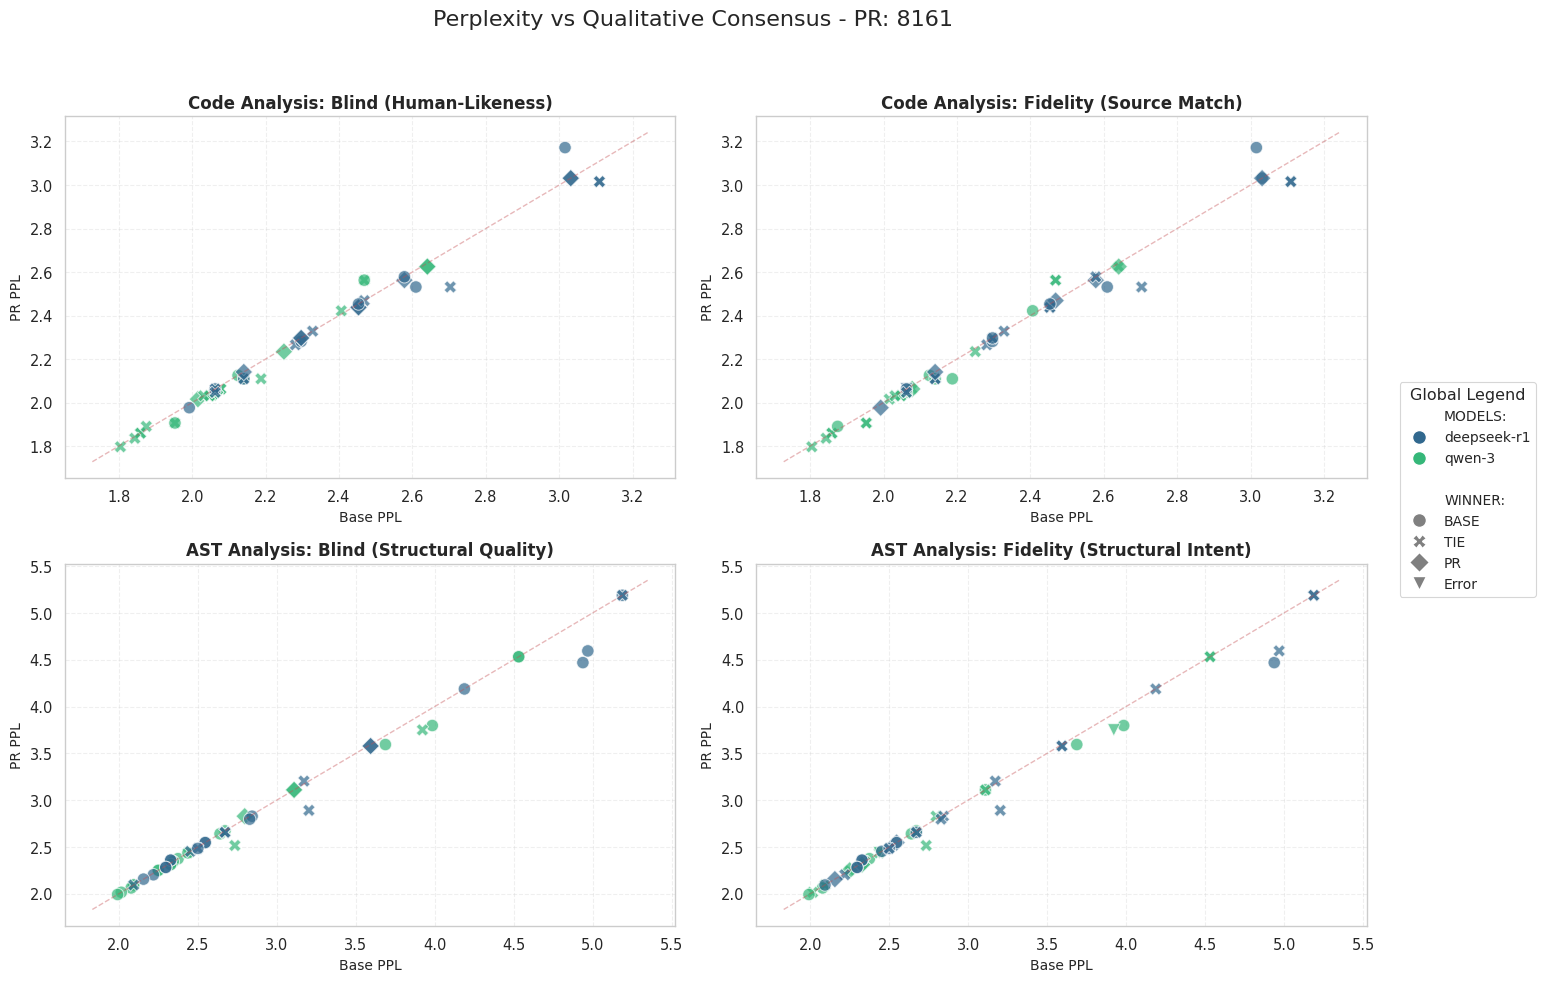

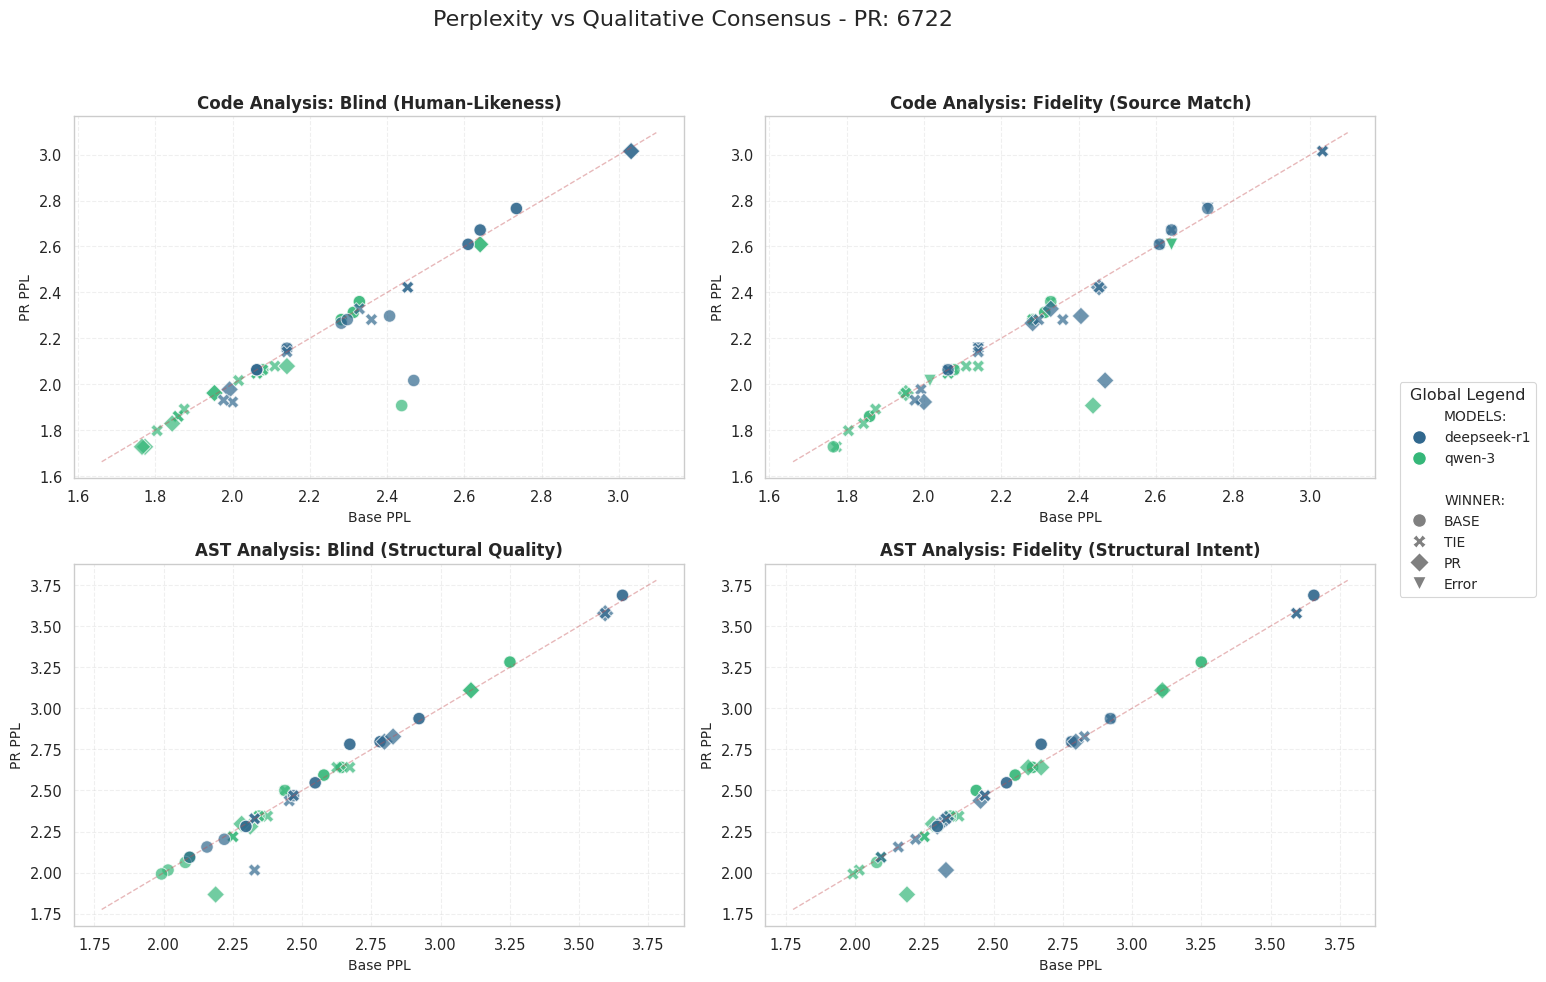

In [124]:
unique_prs = df_reports['pr'].unique()

unique_models = sorted(df_reports['model'].unique())
model_colors = sns.color_palette('viridis', n_colors=len(unique_models))
model_color_map = dict(zip(unique_models, model_colors))
plot_configs = [
    {
        'title': 'Code Analysis: Blind (Human-Likeness)',
        'x': 'base_ppl', 
        'y': 'pr_ppl',
        'style': 'qualitative_winner'
    },
    {
        'title': 'Code Analysis: Fidelity (Source Match)',
        'x': 'base_ppl', 
        'y': 'pr_ppl',
        'style': 'qualitative_winner_s'
    },
    {
        'title': 'AST Analysis: Blind (Structural Quality)',
        'x': 'ast_base_ppl',
        'y': 'ast_pr_ppl', 
        'style': 'qualitative_ast_winner'
    },
    {
        'title': 'AST Analysis: Fidelity (Structural Intent)',
        'x': 'ast_base_ppl', 
        'y': 'ast_pr_ppl',
        'style': 'qualitative_ast_winner_s'
    }
]

STYLE_MAP = {
    'BASE': 'o',
    'TIE': 'X',
    'PR': 'D',
    'Error': 'v'
}

for pr_id in unique_prs:
    df_pr = df_reports[df_reports['pr'] == pr_id]
    
    if df_pr.empty:
        continue

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    fig.suptitle(f'Perplexity vs Qualitative Consensus - PR: {pr_id}', fontsize=16, y=0.98)
    
    handles, labels = [], []

    for i, config in enumerate(plot_configs):
        ax = axes[i]
        x_col = config['x']
        y_col = config['y']
        style_col = config['style']
        
        if x_col not in df_pr.columns or y_col not in df_pr.columns or style_col not in df_pr.columns:
            ax.text(0.5, 0.5, "Missing Data", ha='center', va='center')
            continue
            
        df_plot = df_pr.dropna(subset=[x_col, y_col, style_col])
        
        if df_plot.empty:
            ax.text(0.5, 0.5, "No Valid Data", ha='center', va='center')
            continue

        # Diagonal line for reference
        curr_min = min(df_plot[x_col].min(), df_plot[y_col].min())
        curr_max = max(df_plot[x_col].max(), df_plot[y_col].max())
        margin = (curr_max - curr_min) * 0.05 if curr_max != curr_min else 0.1
        
        ax.plot([curr_min-margin, curr_max+margin], [curr_min-margin, curr_max+margin], 
                'r--', alpha=0.4, linewidth=1) # Removed label from here to avoid duplicate in legend

        sns.scatterplot(
            data=df_plot, 
            x=x_col, 
            y=y_col, 
            hue='model', 
            style=style_col, 
            palette=model_color_map,
            s=80,            
            alpha=0.7,
            markers=STYLE_MAP,
            ax=ax,
            legend=False
        )
        
        ax.set_title(config['title'], fontsize=12, fontweight='bold')
        ax.set_xlabel(f'Base PPL', fontsize=10)
        ax.set_ylabel(f'PR PPL', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.3)

        legend_elements = []
        
    # Sezione Modelli (Colori)
    legend_elements.append(mlines.Line2D([], [], color='none', label='MODELS:'))
    for model in unique_models:
        legend_elements.append(mlines.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=model_color_map[model], markersize=10, label=model))
    
    # Spazio vuoto
    legend_elements.append(mlines.Line2D([], [], color='none', label=' '))
    
    # Sezione Risultati (Style)
    legend_elements.append(mlines.Line2D([], [], color='none', label='WINNER:'))
    for label, marker in STYLE_MAP.items():
        if label == 'unknown': continue
        legend_elements.append(mlines.Line2D([0], [0], marker=marker, color='w', 
                                markerfacecolor='gray', markersize=10, label=label))

    # Posizionamento legenda a destra o sotto
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), 
                frameon=True, fontsize=10, title="Global Legend")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    

### Check length Bias

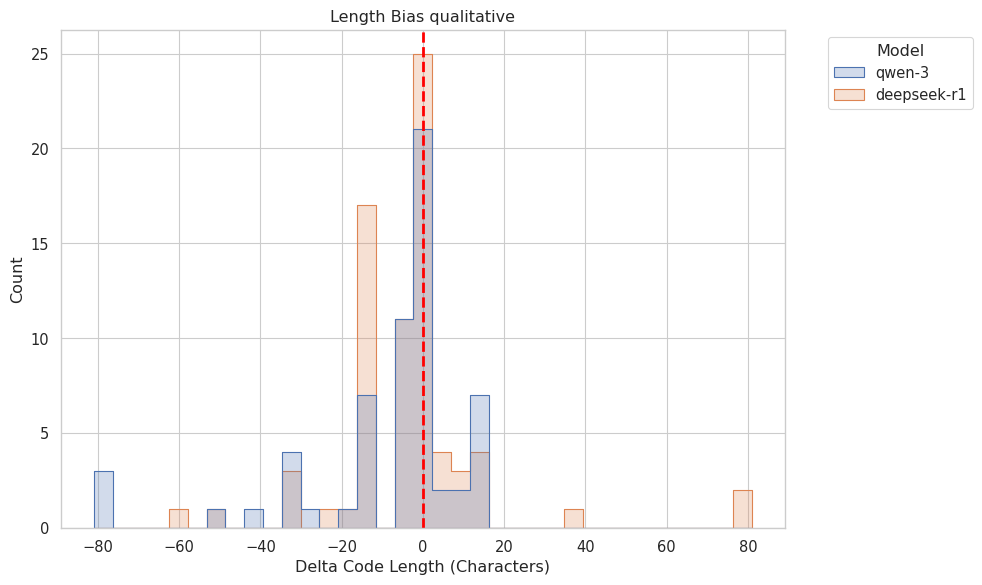

Average Length Bias: -5.79 chars (Positive = prefers longer, Negative = prefers shorter)


In [125]:
df_bias = df_reports.copy()

valid_pr_labels = ['pr',]
valid_base_labels = ['base']

df_bias['qualitative_winner'] = df_bias['qualitative_winner'].astype(str).str.lower().str.strip()

mask_valid = df_bias['qualitative_winner'].isin(valid_pr_labels + valid_base_labels)
df_bias = df_bias[mask_valid].copy()


def get_winner_len_delta(row):
    w = row['qualitative_winner']
    if w in valid_pr_labels:
        return row['ast_len_change']
    elif w in valid_base_labels:
        return -row['ast_len_change']
    return None

df_bias['ast_delta_len_winner'] = df_bias.apply(get_winner_len_delta, axis=1)

df_bias = df_bias.dropna(subset=['ast_delta_len_winner'])

plt.figure(figsize=(10, 6))

ax = sns.histplot(
    data=df_bias, 
    x='ast_delta_len_winner', 
    hue='model', 
    element="step", 
    #kde=True,
    #palette='viridis'
)

plt.axvline(0, color='red', linestyle='--', linewidth=2, label='No Length Diff')

plt.title('Length Bias qualitative')
plt.xlabel('Delta Code Length (Characters)')
plt.ylabel('Count')
try:
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1), title='Model')
except AttributeError:
    # Fallback 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')
plt.tight_layout()
plt.show()

mean_bias = df_bias['ast_delta_len_winner'].mean()
print(f"Average Length Bias: {mean_bias:.2f} chars (Positive = prefers longer, Negative = prefers shorter)")

## Check position Bias

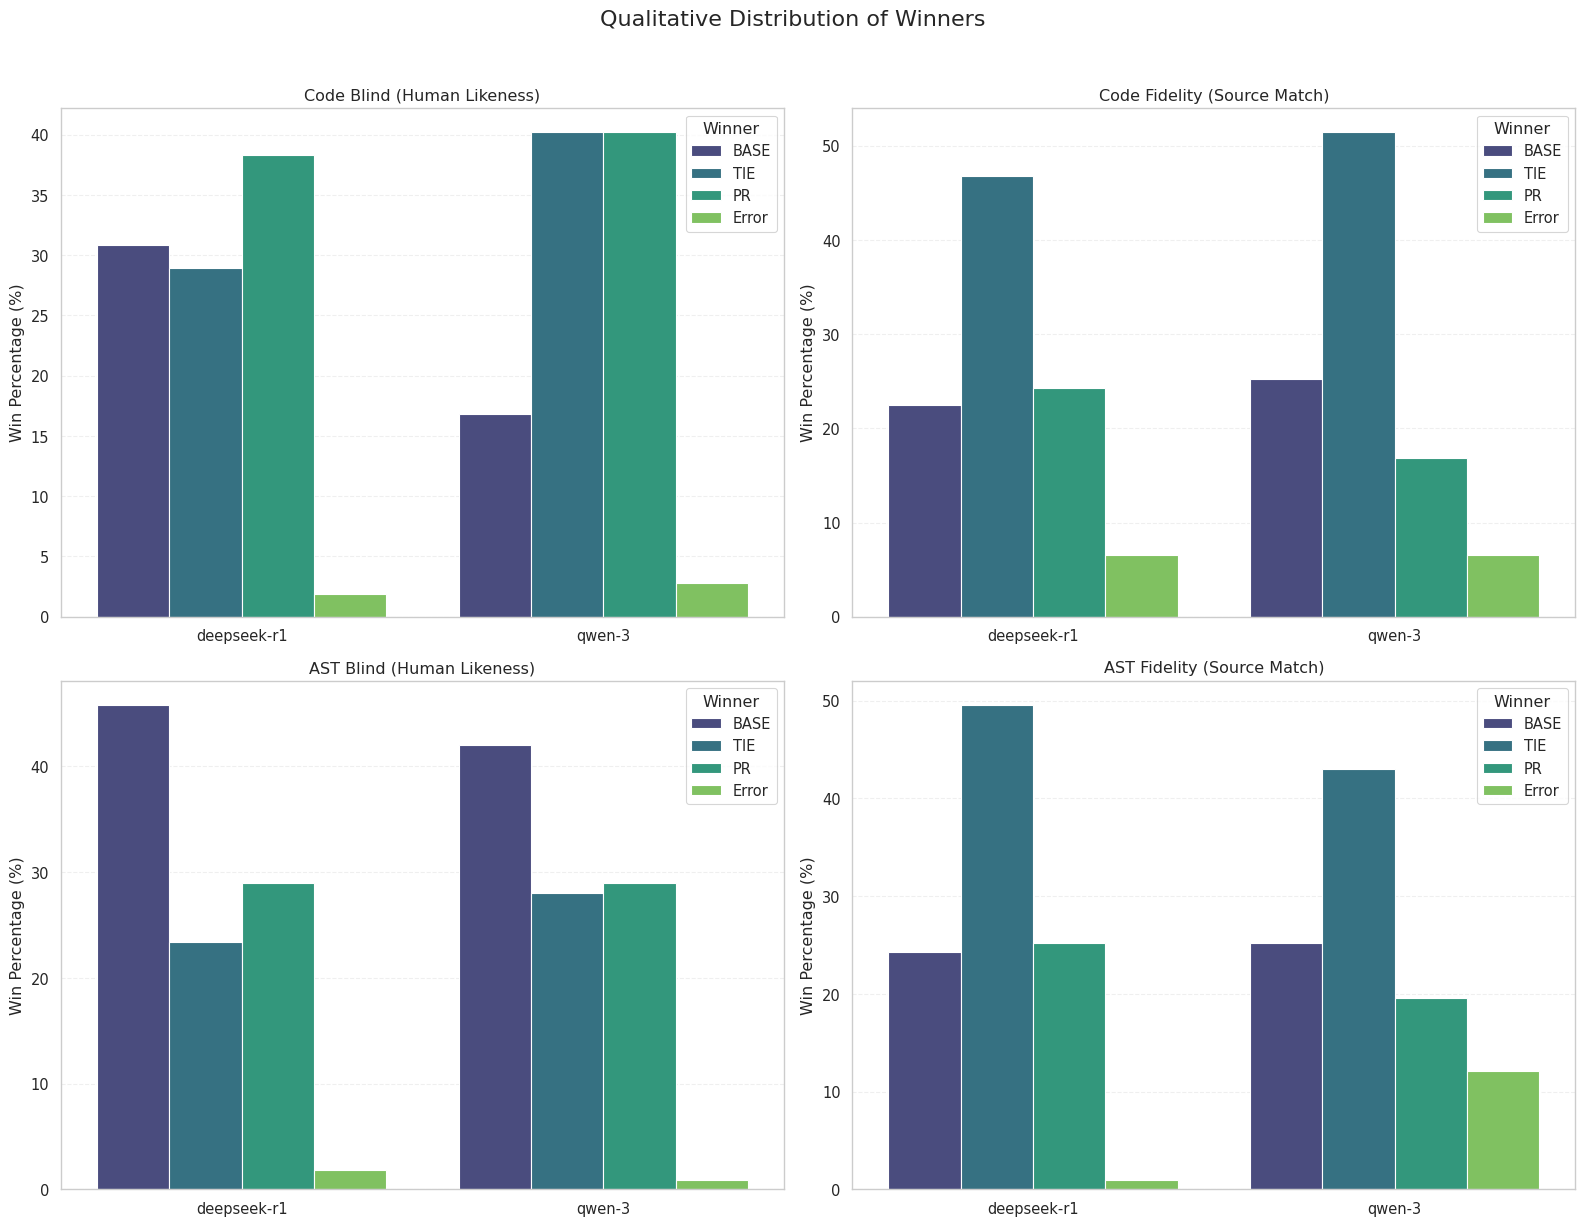

In [126]:
def plot_bias_control_grid(df):
    analysis_types = [
        ('qualitative_winner', 'Code Blind (Human Likeness)'),
        ('qualitative_winner_s', 'Code Fidelity (Source Match)'),
        ('qualitative_ast_winner', 'AST Blind (Human Likeness)'),
        ('qualitative_ast_winner_s', 'AST Fidelity (Source Match)')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, (col, title) in enumerate(analysis_types):
        df_valid = df.dropna(subset=[col]).copy()
        
        if df_valid.empty:
            axes[i].text(0.5, 0.5, "No Data", ha='center', va='center')
            axes[i].set_title(title)
            continue
            
        counts = df_valid.groupby(['model', col]).size().reset_index(name='count')
        totals = df_valid.groupby('model').size().reset_index(name='total')
        data = counts.merge(totals, on='model')
        data['percentage'] = data['count'] / data['total'] * 100

        ORDER = ['BASE', 'TIE', 'PR', 'Error']
        
        sns.barplot(
            data=data,
            x='model',
            y='percentage',
            hue=col,
            palette='viridis',
            hue_order=ORDER,
            ax=axes[i]
        )
        
        axes[i].set_title(f'{title}')
        axes[i].set_ylabel('Win Percentage (%)')
        axes[i].set_xlabel('')
        axes[i].legend(title='Winner', loc='upper right')
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)

    plt.suptitle("Qualitative Distribution of Winners", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_bias_control_grid(df_reports)

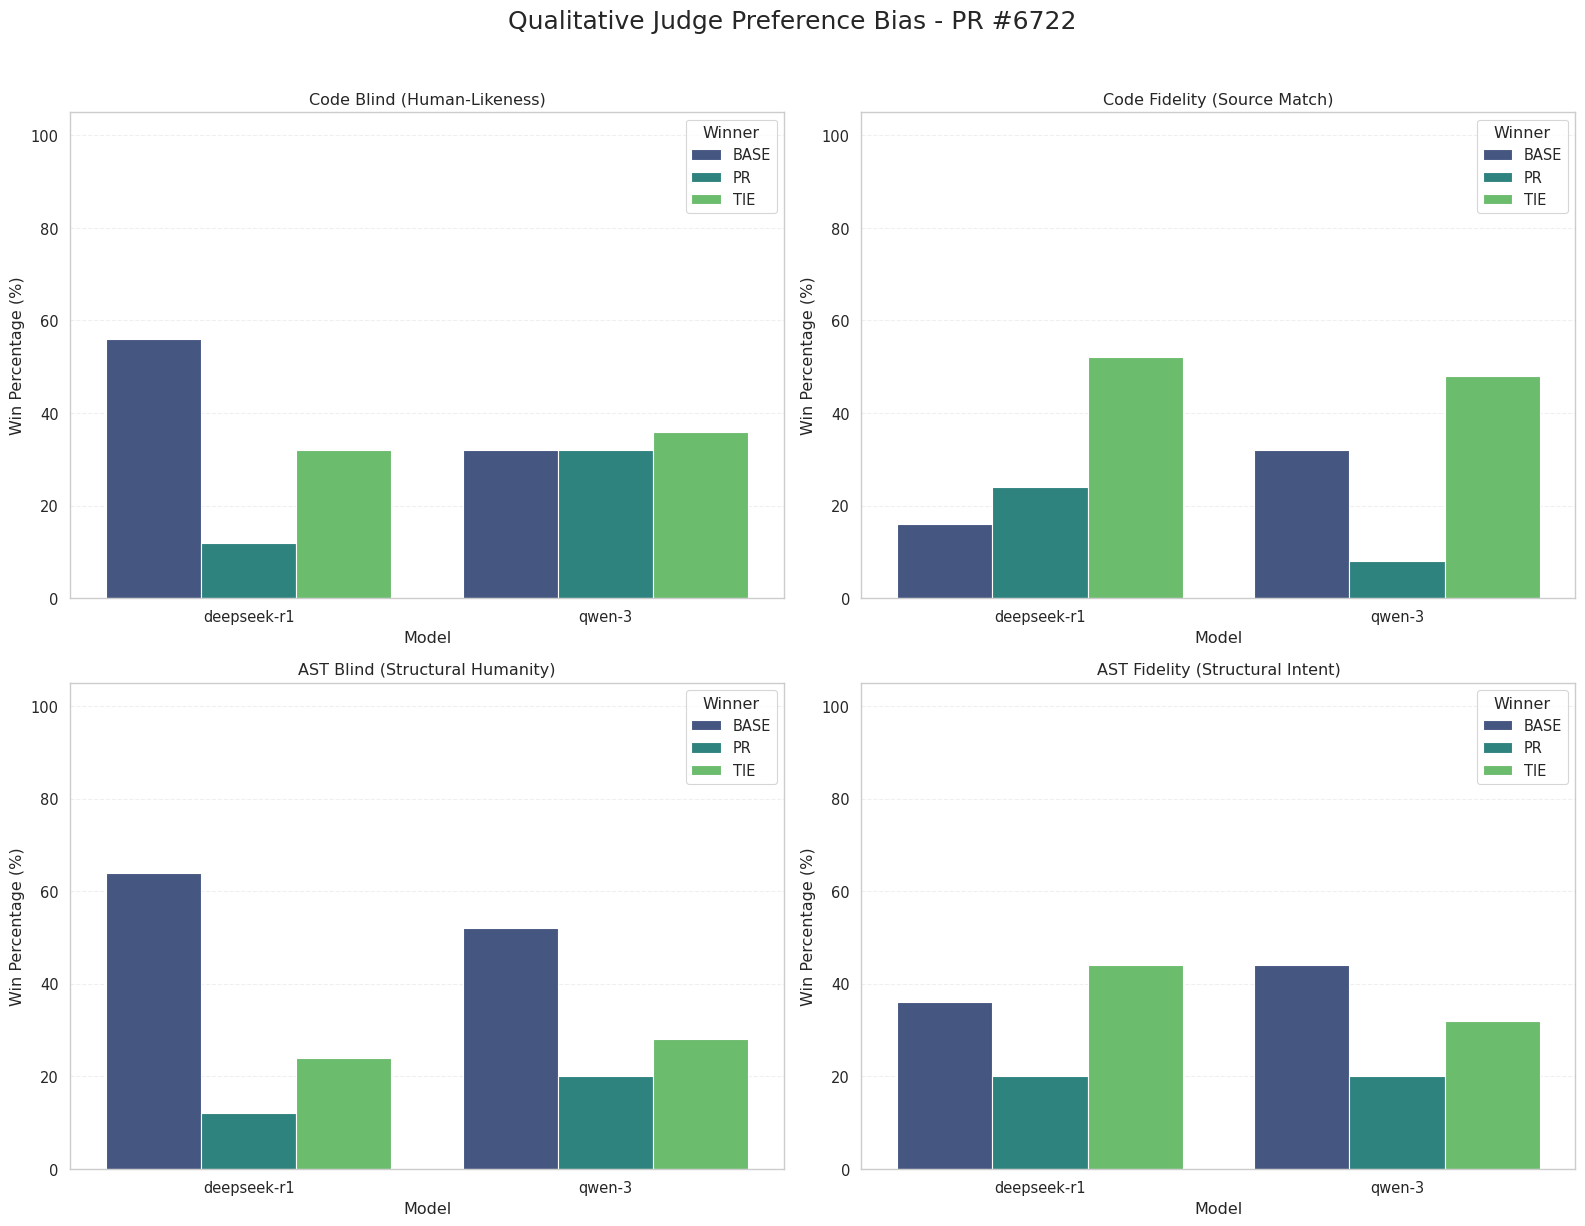

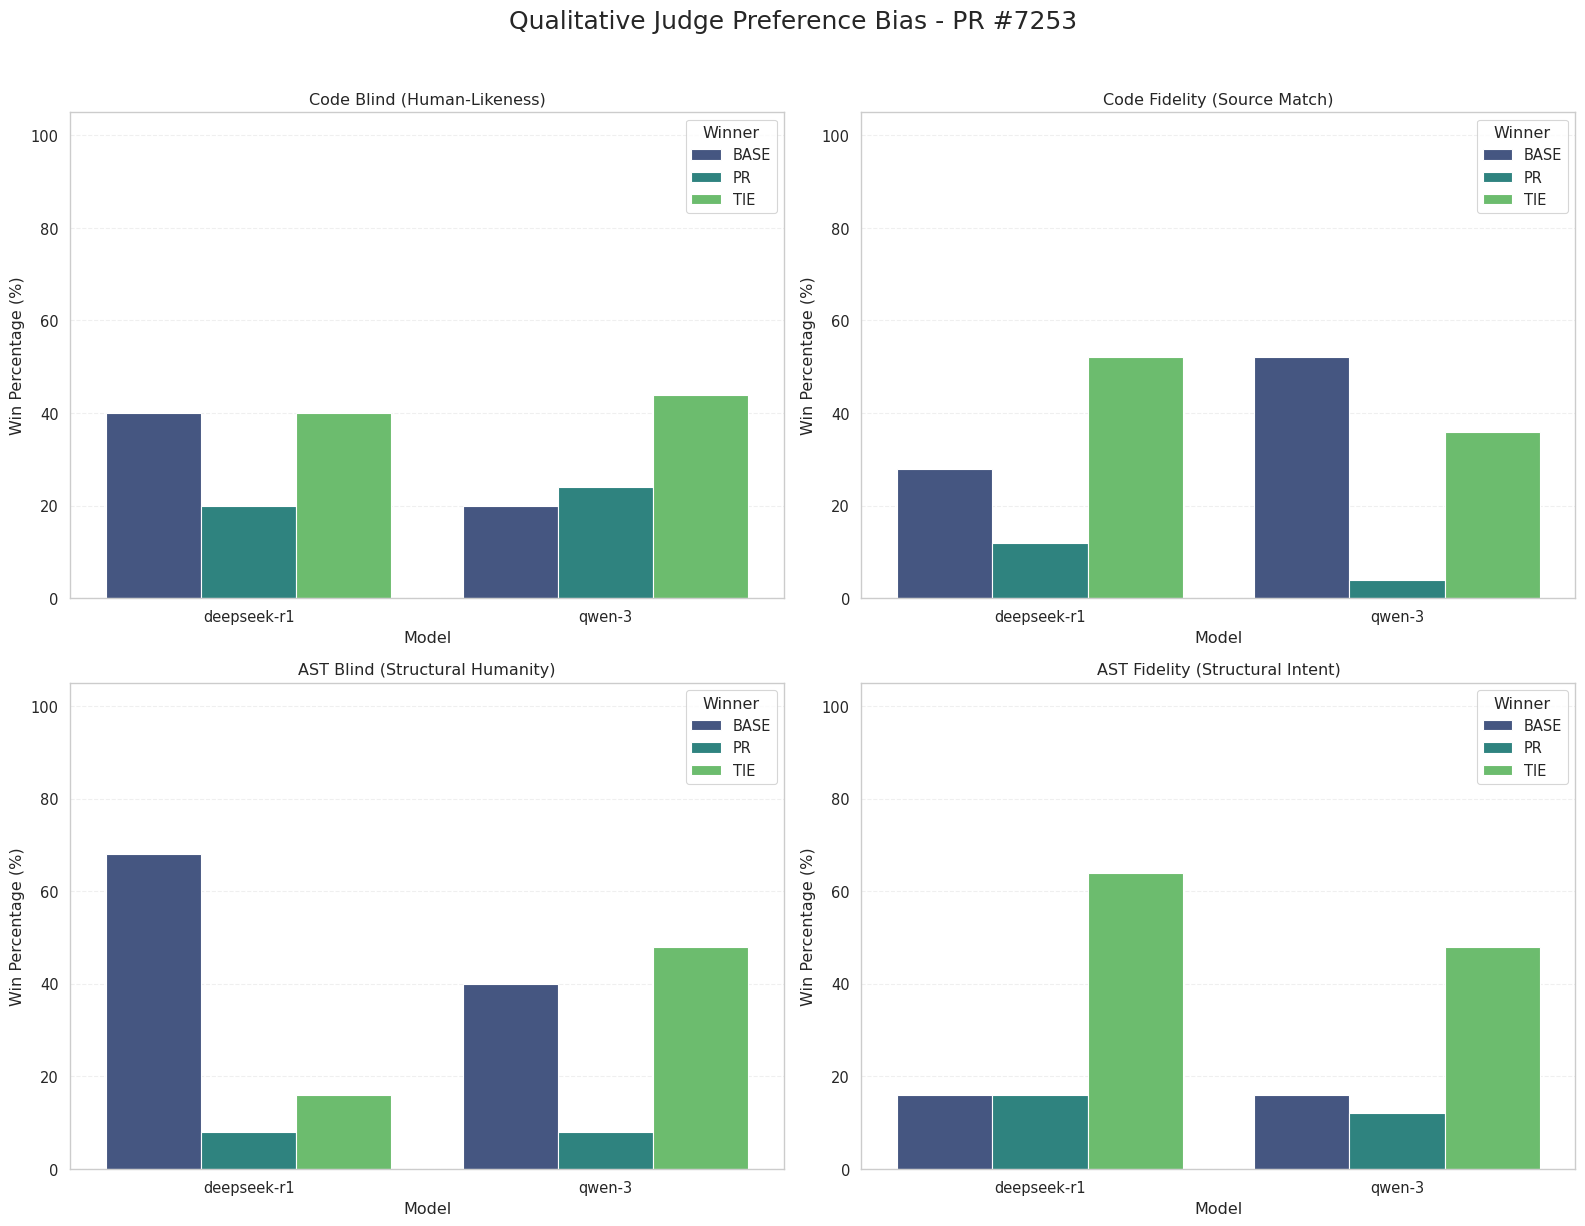

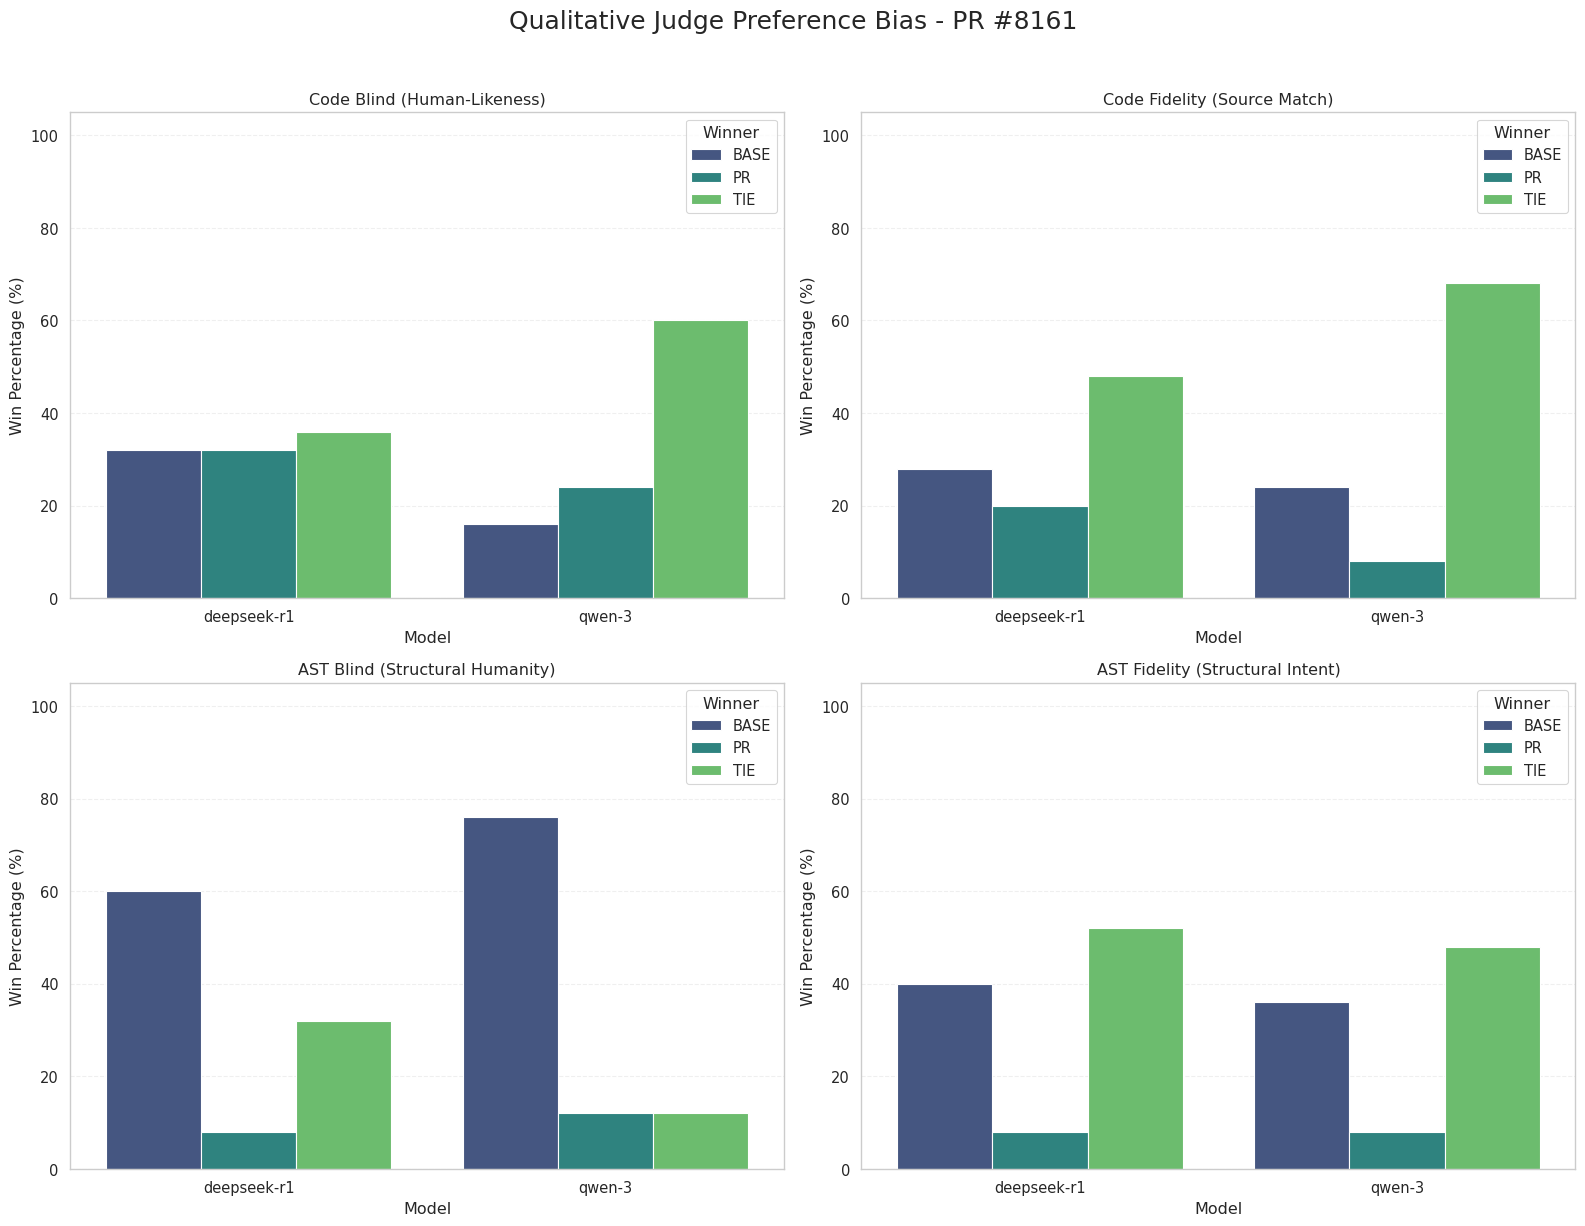

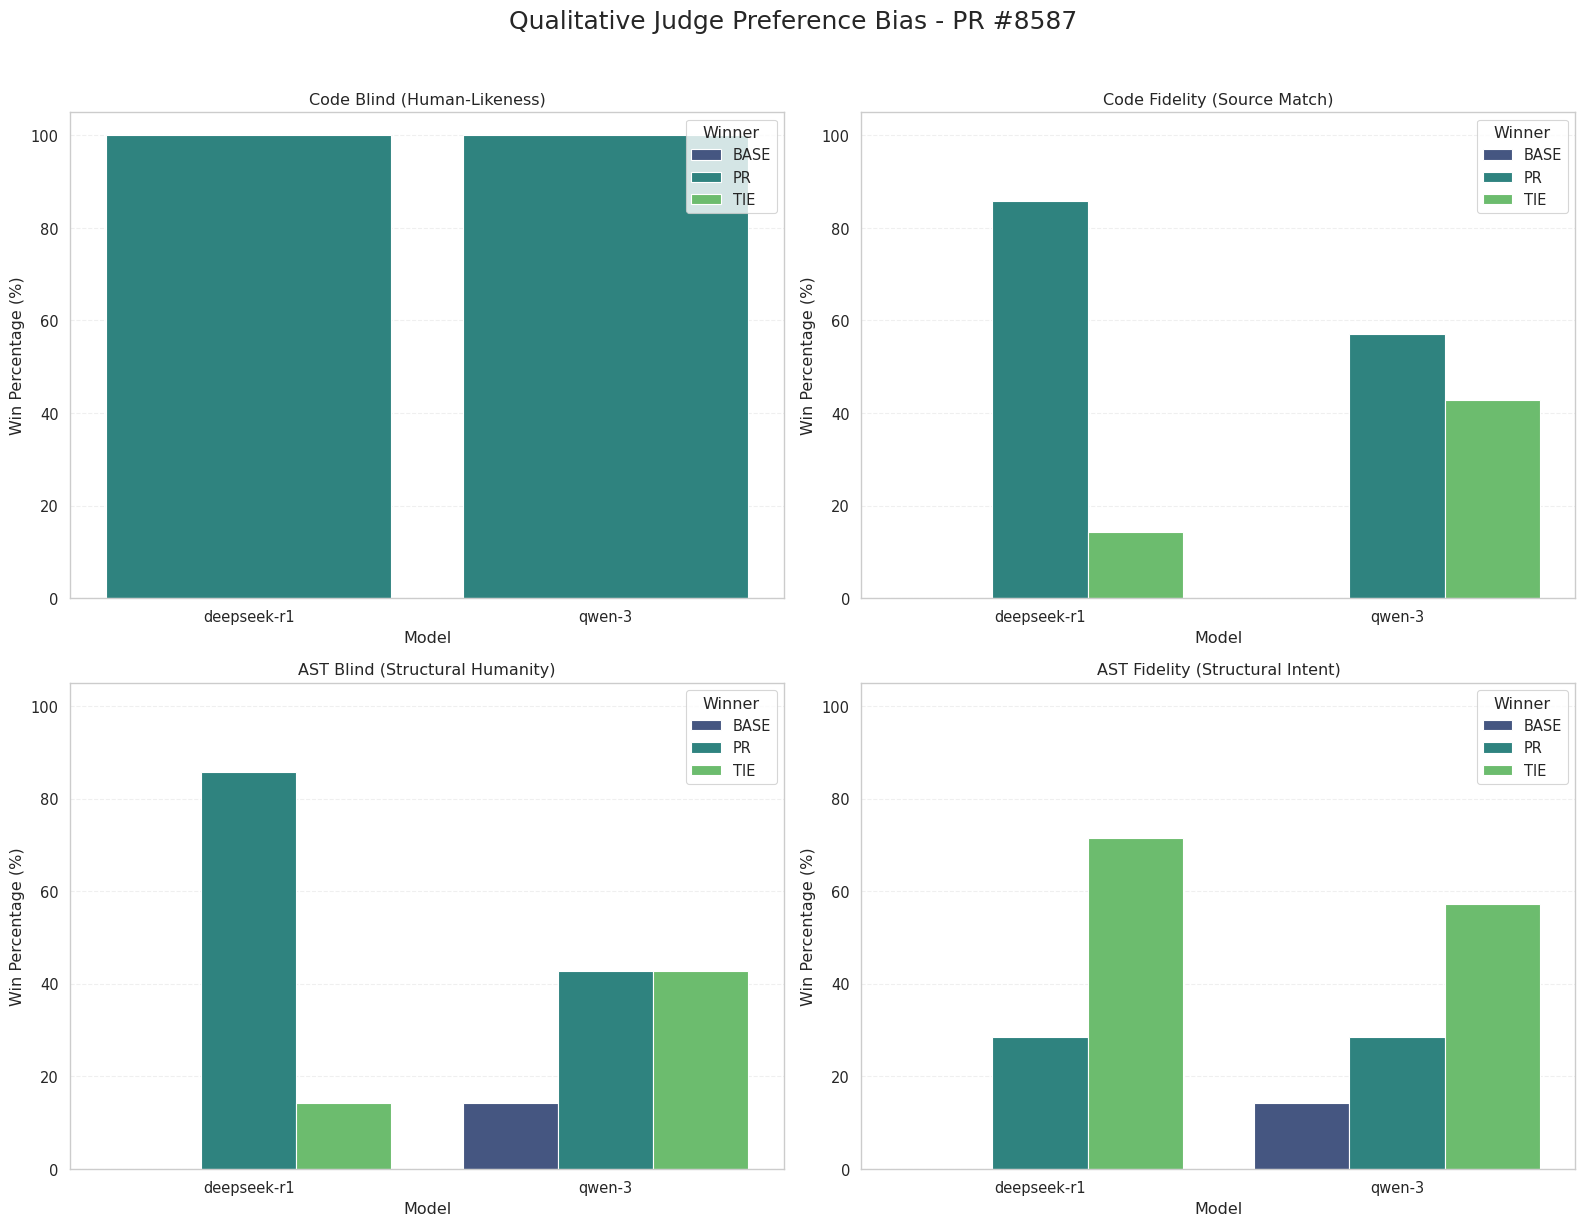

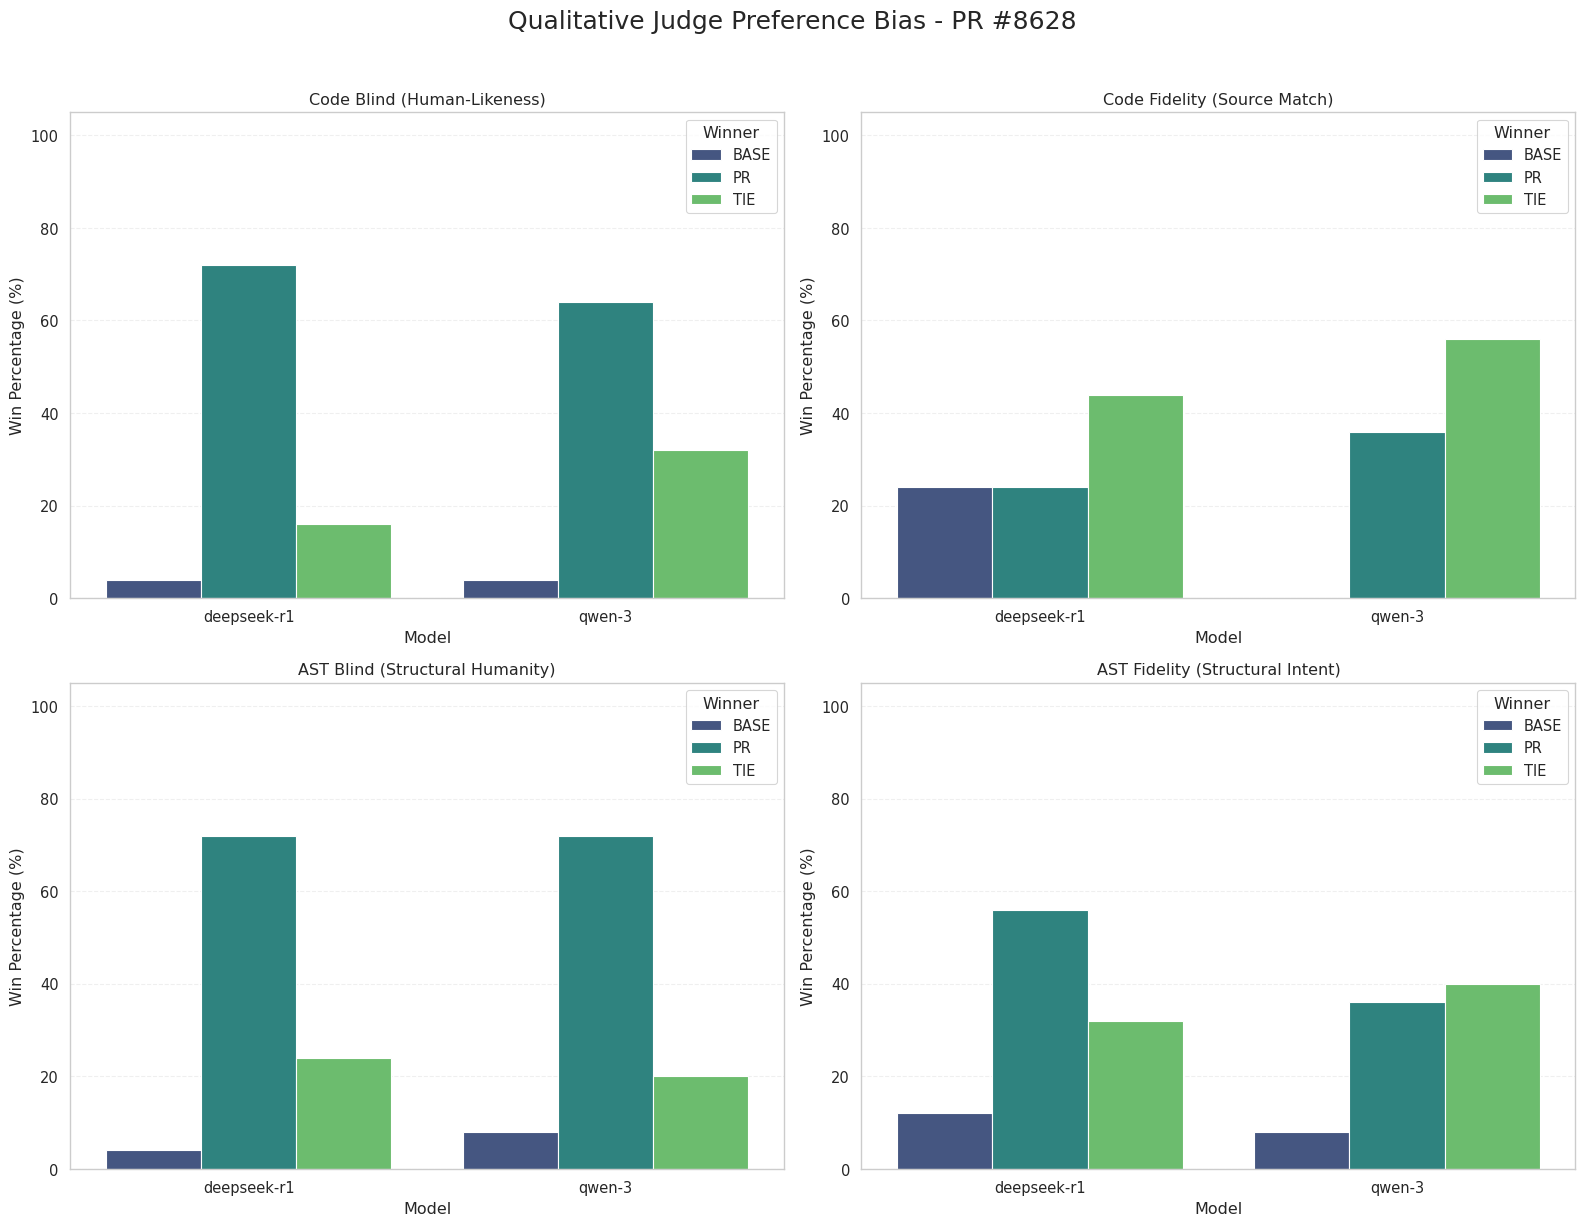

In [127]:
def plot_bias_per_pr(df):
    analysis_types = [
        ('qualitative_winner', 'Code Blind (Human-Likeness)'),
        ('qualitative_winner_s', 'Code Fidelity (Source Match)'),
        ('qualitative_ast_winner', 'AST Blind (Structural Humanity)'),
        ('qualitative_ast_winner_s', 'AST Fidelity (Structural Intent)')
    ]
    
    ORDER = ['BASE', 'PR','TIE']#, 'Error']
    
    unique_prs = sorted(df['pr'].dropna().unique())

    for pr_id in unique_prs:
        df_pr = df[df['pr'] == pr_id].copy()
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for i, (col, title) in enumerate(analysis_types):
            df_valid = df_pr.dropna(subset=[col]).copy()
            
            if df_valid.empty:
                axes[i].text(0.5, 0.5, "No Data for this PR", ha='center', va='center')
                axes[i].set_title(title)
                continue
            
            counts = df_valid.groupby(['model', col]).size().reset_index(name='count')
            totals = df_valid.groupby('model').size().reset_index(name='total')
            data = counts.merge(totals, on='model')
            data['percentage'] = (data['count'] / data['total']) * 100

            sns.barplot(
                data=data,
                x='model',
                y='percentage',
                hue=col,
                palette='viridis',
                hue_order=ORDER, 
                ax=axes[i]
            )
            
            axes[i].set_title(f'{title}')
            axes[i].set_ylabel('Win Percentage (%)')
            axes[i].set_xlabel('Model')
            axes[i].set_ylim(0, 105)
            axes[i].legend(title='Winner', loc='upper right')
            axes[i].grid(axis='y', linestyle='--', alpha=0.3)

        plt.suptitle(f"Qualitative Judge Preference Bias - PR #{pr_id}", fontsize=18, y=1.02)
        plt.tight_layout()
        
        plt.show()


plot_bias_per_pr(df_reports)

## Coherence ad alignment

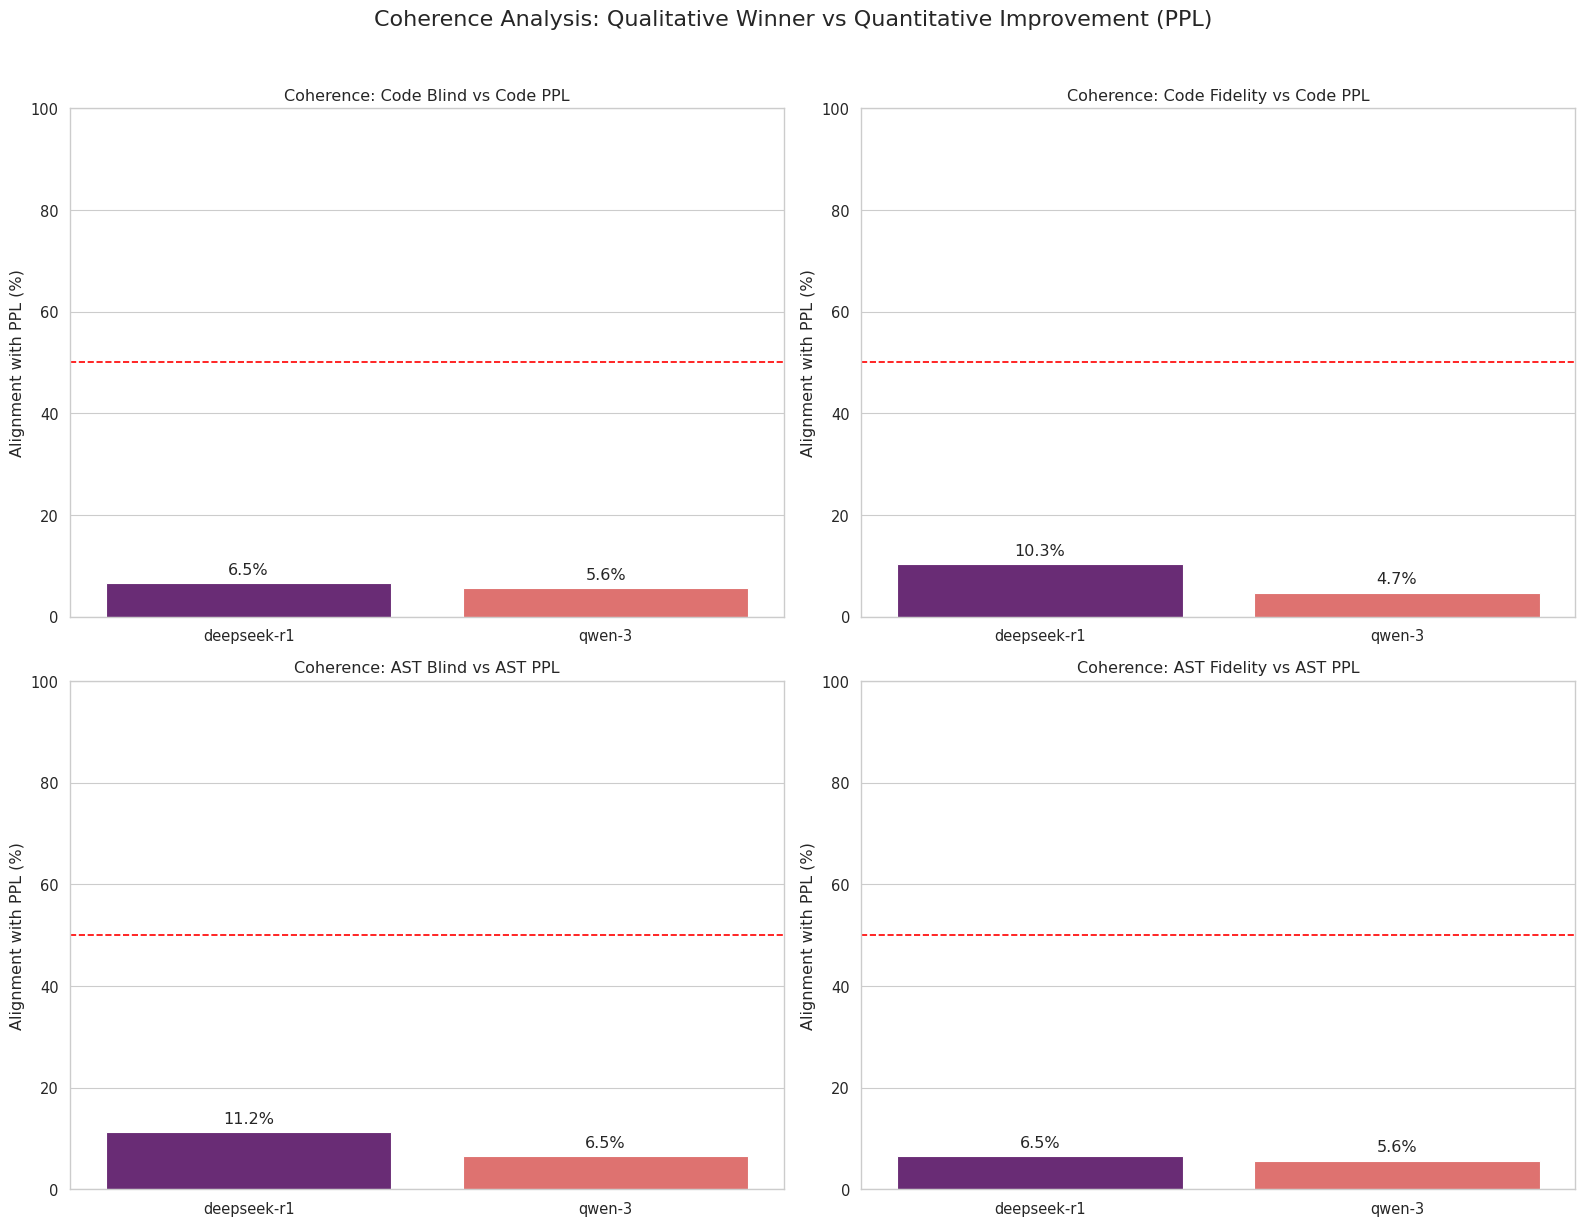

In [128]:
def plot_coherence_control_grid(df):
    analysis_pairs = [
        ('qualitative_winner', 'delta_ppl', 'Code Blind vs Code PPL'),
        ('qualitative_winner_s', 'delta_ppl', 'Code Fidelity vs Code PPL'),
        ('qualitative_ast_winner', 'ast_delta_ppl', 'AST Blind vs AST PPL'),
        ('qualitative_ast_winner_s', 'ast_delta_ppl', 'AST Fidelity vs AST PPL')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    THRESHOLD = 0.05
    
    for i, (qual_col, quant_col, title) in enumerate(analysis_pairs):
        df_valid = df.dropna(subset=[qual_col, quant_col]).copy()
        
        if df_valid.empty:
            axes[i].text(0.5, 0.5, "No Data", ha='center', va='center')
            axes[i].set_title(title)
            continue

        # PR win (Qual) ,delta < 0 (Quant) -> Aligned
        # BASE win (Qual) , delta > 0 (Quant) -> Aligned
        # TIE (Qual) -> Neutral ignored for this plot, here we count it as Non-Aligned if PPL changes significantly
        
        def check_alignment(row):
            w_qual = str(row[qual_col]).upper()
            d_quant = row[quant_col]
            
            if w_qual == 'PR' and d_quant < -THRESHOLD: return True
            if w_qual == 'BASE' and d_quant > THRESHOLD: return True
            #if w_qual == 'TIE' and abs(d_quant) <= THRESHOLD: return True
            return False

        df_valid['is_aligned'] = df_valid.apply(check_alignment, axis=1)
        
        alignment_stats = df_valid.groupby('model')['is_aligned'].mean().reset_index()
        alignment_stats['percentage'] = alignment_stats['is_aligned'] * 100
        
        sns.barplot(
            data=alignment_stats,
            x='model',
            y='percentage',
            hue='model',
            palette='magma',
            ax=axes[i],
            dodge=False
        )
        
        axes[i].set_title(f'Coherence: {title}')
        axes[i].set_ylabel('Alignment with PPL (%)')
        axes[i].set_xlabel('')
        axes[i].set_ylim(0, 100)
        axes[i].axhline(50, color='red', linestyle='--', label='Random (50%)')
        axes[i].legend().remove()
        
        for p in axes[i].patches:
            axes[i].annotate(f'{p.get_height():.1f}%', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.suptitle("Coherence Analysis: Qualitative Winner vs Quantitative Improvement (PPL)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_coherence_control_grid(df_reports)

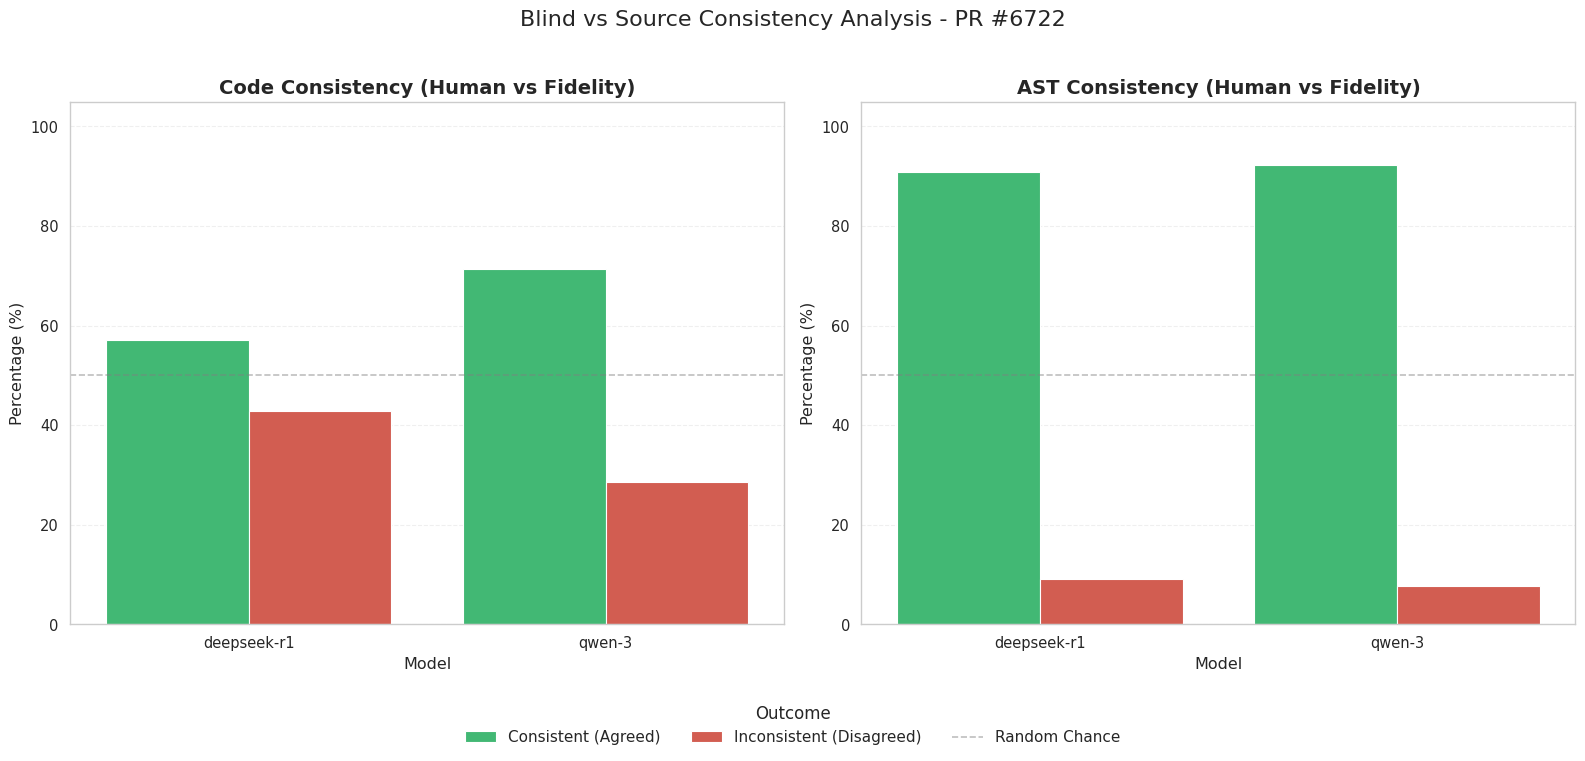

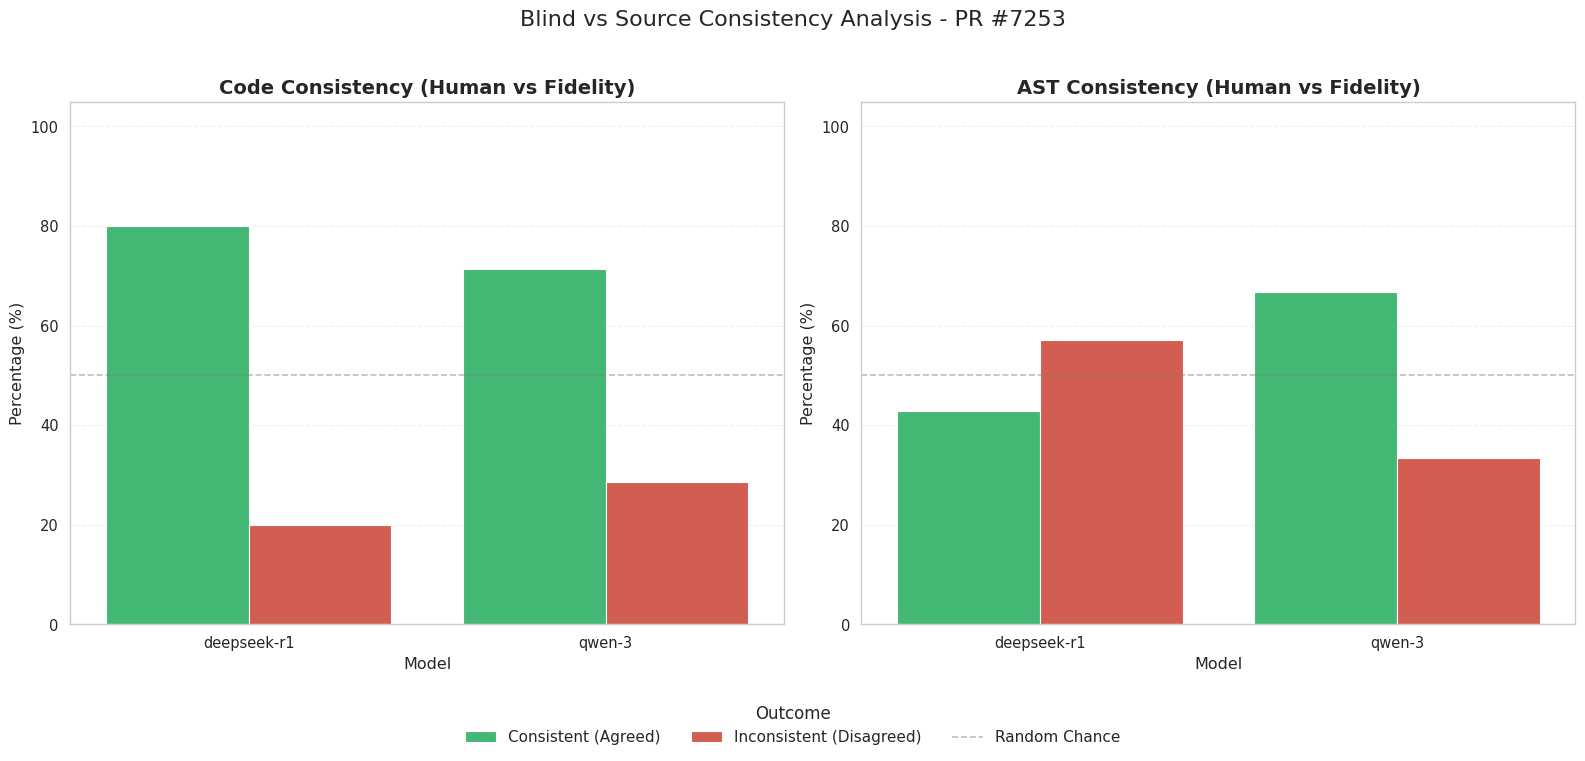

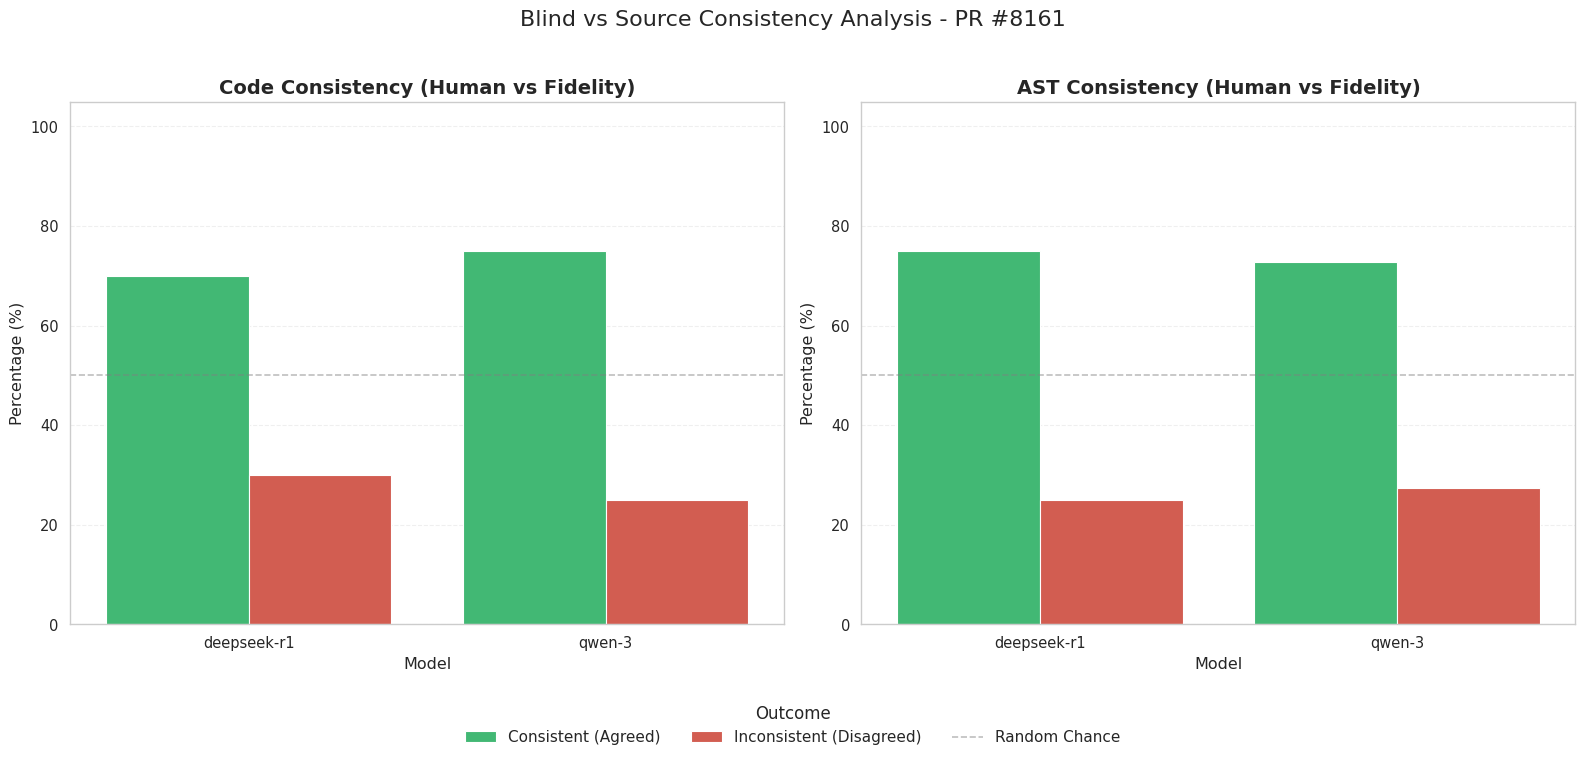

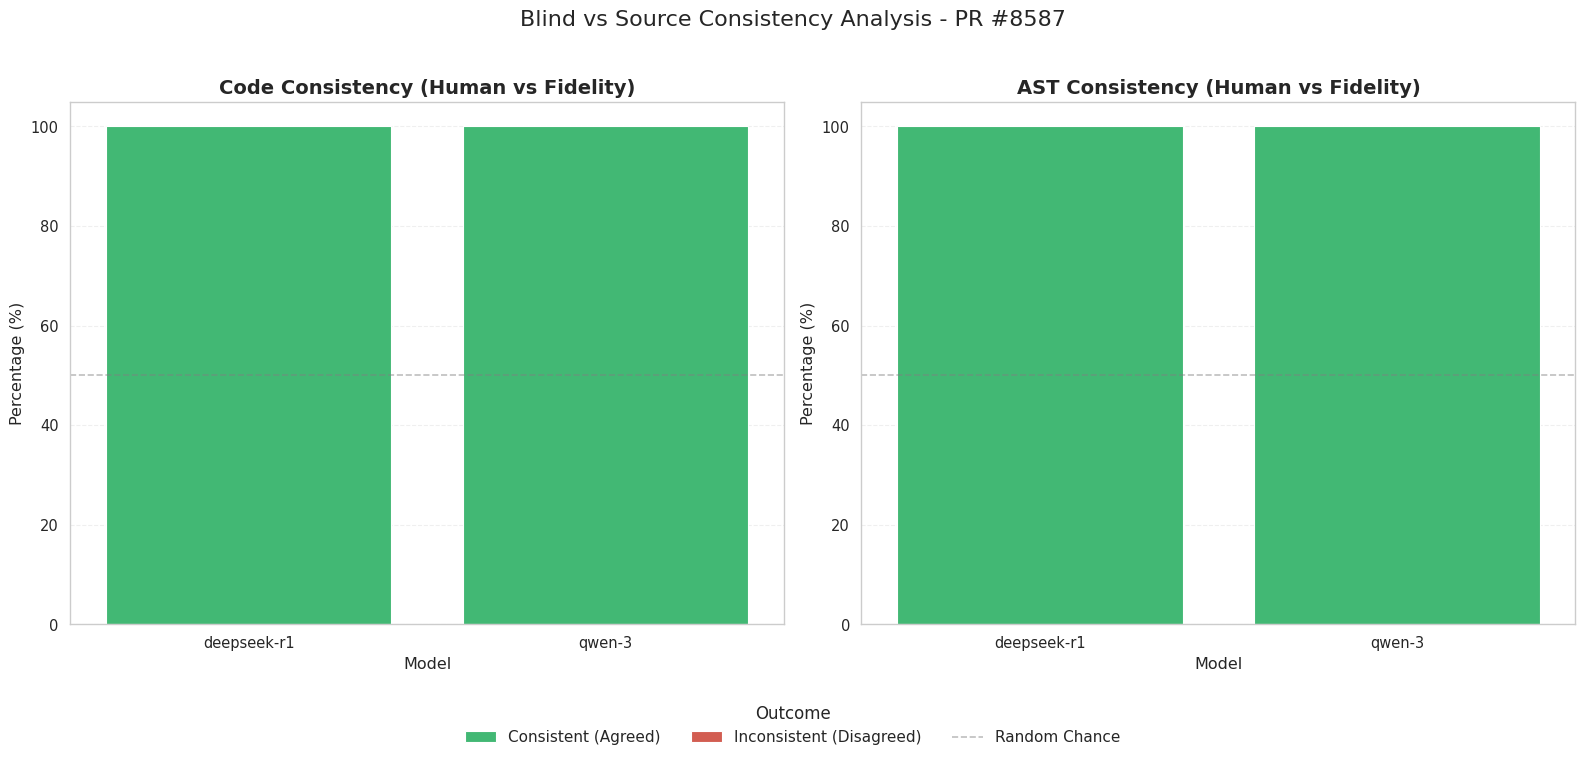

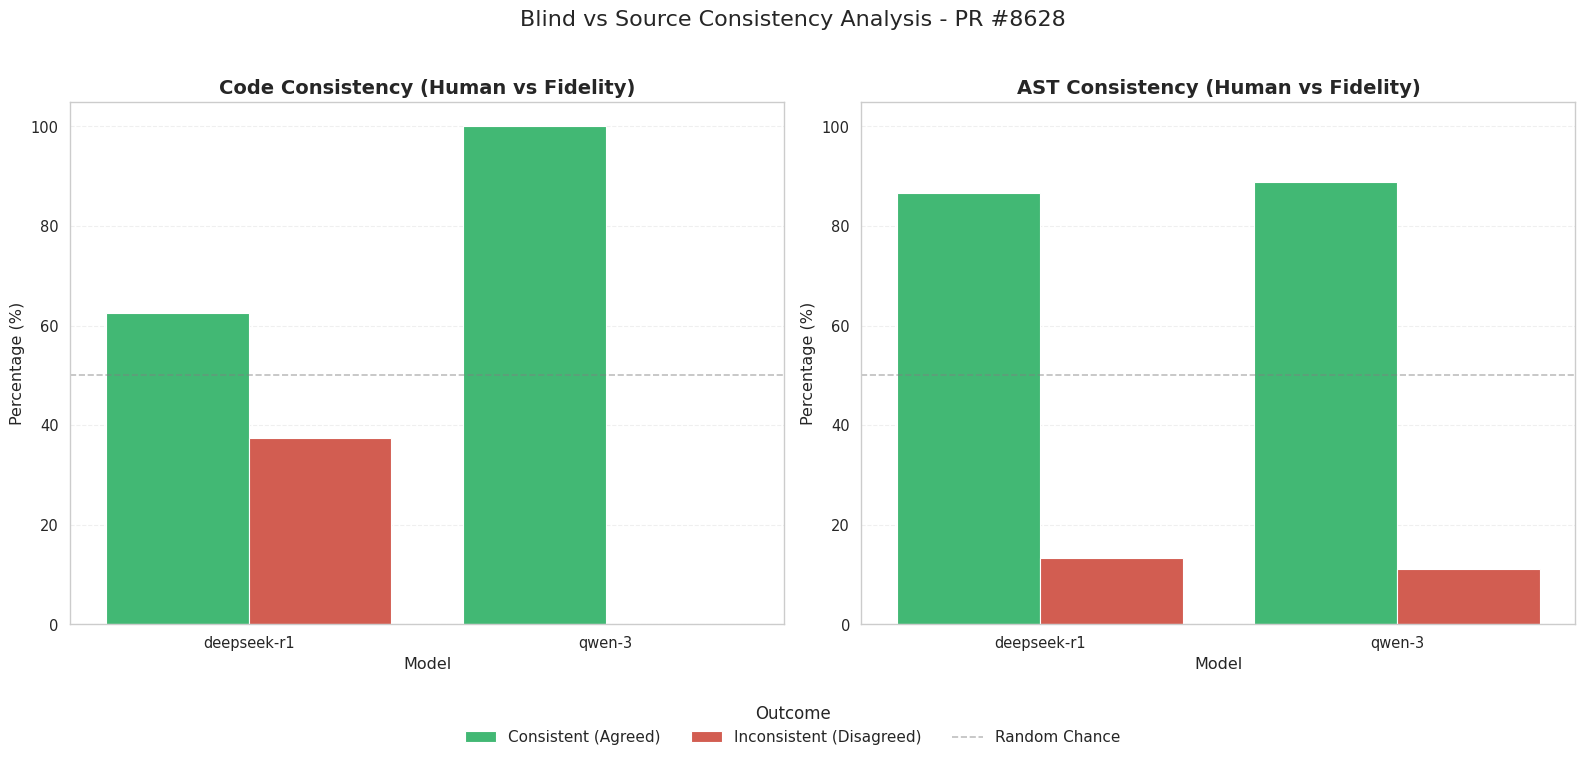

In [129]:
def plot_consistency_analysis(df):
    comparison_pairs = [
        ('qualitative_winner', 'qualitative_winner_s', 'Code Consistency (Human vs Fidelity)'),
        ('qualitative_ast_winner', 'qualitative_ast_winner_s', 'AST Consistency (Human vs Fidelity)')
    ]
    
    unique_prs = sorted(df['pr'].dropna().unique())
    
    for pr_id in unique_prs:
        df_pr = df[df['pr'] == pr_id].copy()
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        axes = axes.flatten()
        
        has_data = False

        for i, (blind_col, source_col, title) in enumerate(comparison_pairs):
            valid_outcomes = ['BASE', 'PR']
            
            df_valid = df_pr[
                (df_pr[blind_col].isin(valid_outcomes)) & 
                (df_pr[source_col].isin(valid_outcomes))
            ].copy()
            
            if df_valid.empty:
                axes[i].text(0.5, 0.5, "Not enough decisive data\n(Too many TIEs/Errors)", 
                             ha='center', va='center', fontsize=12)
                axes[i].set_title(title)
                continue
            
            has_data = True

            df_valid['outcome'] = np.where(
                df_valid[blind_col] == df_valid[source_col], 
                'Consistent (Agreed)', 
                'Inconsistent (Disagreed)'
            )
            
            counts = df_valid.groupby(['model', 'outcome']).size().reset_index(name='count')
            total_per_model = counts.groupby('model')['count'].sum().reset_index(name='total')
            counts = counts.merge(total_per_model, on='model')
            
            counts['percentage'] = (counts['count'] / counts['total']) * 100
            
            hue_order = ['Consistent (Agreed)', 'Inconsistent (Disagreed)']
            colors = {'Consistent (Agreed)': '#2ecc71', 'Inconsistent (Disagreed)': '#e74c3c'}

            sns.barplot(
                data=counts,
                x='model',
                y='percentage',
                hue='outcome',
                hue_order=hue_order,
                palette=colors,
                ax=axes[i]
            )
            
            if axes[i].get_legend() is not None:
                axes[i].get_legend().remove()
            
            axes[i].set_title(title, fontsize=14, fontweight='bold')
            axes[i].set_ylabel('Percentage (%)')
            axes[i].set_xlabel('Model')
            axes[i].set_ylim(0, 105)
            
            axes[i].axhline(50, color='gray', linestyle='--', alpha=0.5, label='Random Chance')
            
            axes[i].grid(axis='y', linestyle='--', alpha=0.3)

        if has_data:
            plt.suptitle(f"Blind vs Source Consistency Analysis - PR #{pr_id}", fontsize=16, y=1.02)
            
            # COMMON LEGEND 
            handles, labels = axes[i].get_legend_handles_labels()
            

            fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
                       ncol=3, title='Outcome', fontsize=11, title_fontsize=12, frameon=False)
            
            plt.tight_layout(rect=[0, 0.05, 1, 1])
            plt.show()
        else:
            plt.close()


plot_consistency_analysis(df_reports)


[PR #6722] Inconsistent decisions found:
  Model: deepseek-r1
    - Binary: task-readstat_sav_parse_long_variable_names_record-O0.so (Code chose: PR | AST chose: BASE)
    - Binary: task-xz_lzma_index_hash_decode-O2.so (Code chose: BASE | AST chose: PR)
  Model: qwen-3
    - Binary: task-file_file_signextend-O0.so (Code chose: BASE | AST chose: PR)
    - Binary: task-readstat_sav_parse_very_long_string_record-O0.so (Code chose: PR | AST chose: BASE)
    - Binary: task-xz_lzma_validate_chain-O3.so (Code chose: PR | AST chose: BASE)
--------------------------------------------------


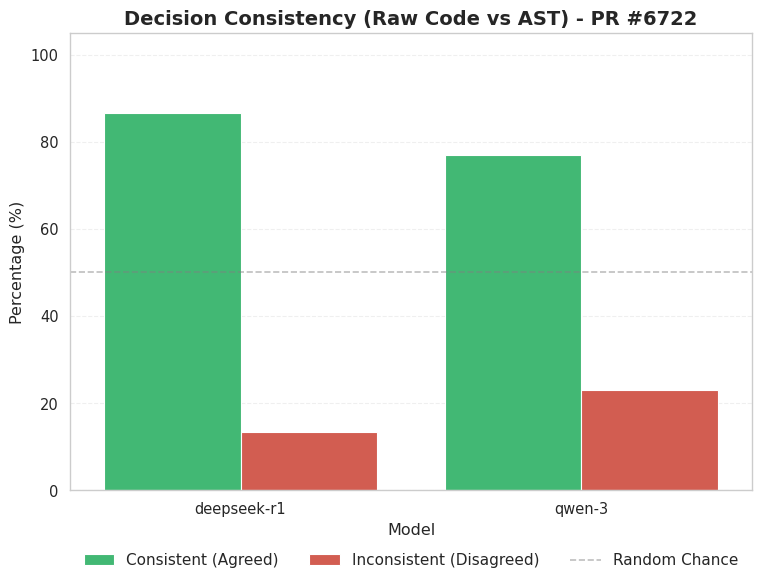


[PR #7253] Inconsistent decisions found:
  Model: deepseek-r1
    - Binary: task-file_file_signextend-O2.so (Code chose: BASE | AST chose: PR)
    - Binary: task-libxls_xls_parseWorkBook-O0.so (Code chose: PR | AST chose: BASE)
    - Binary: task-readstat_sav_parse_very_long_string_record-O2.so (Code chose: PR | AST chose: BASE)
    - Binary: task-xz_lzma_validate_chain-O2.so (Code chose: PR | AST chose: BASE)
  Model: qwen-3
    - Binary: task-libxls_xls_parseWorkBook-O0.so (Code chose: PR | AST chose: BASE)
    - Binary: task-readstat_sav_parse_long_variable_names_record-O3.so (Code chose: PR | AST chose: BASE)
    - Binary: task-readstat_sav_parse_very_long_string_record-O2.so (Code chose: PR | AST chose: BASE)
    - Binary: task-readstat_sav_parse_long_variable_names_record-O0.so (Code chose: PR | AST chose: BASE)
    - Binary: task-readstat_sav_parse_very_long_string_record-O0.so (Code chose: PR | AST chose: BASE)
--------------------------------------------------


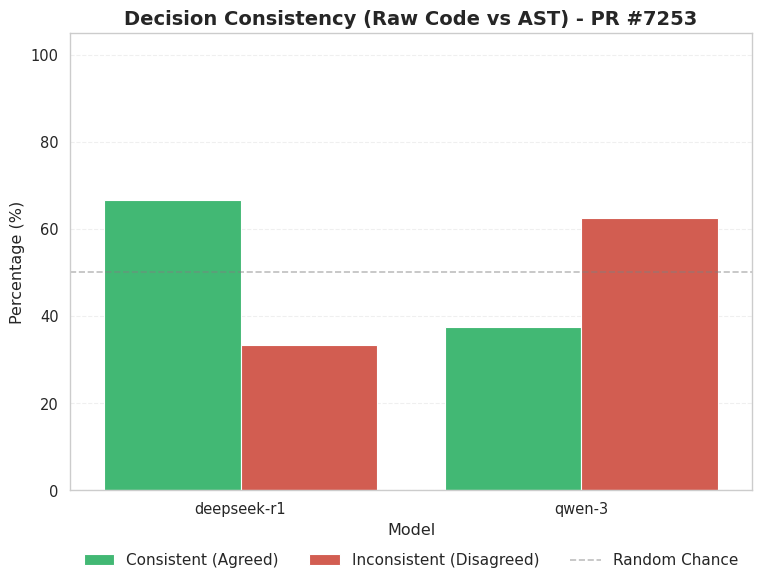


[PR #8161] Inconsistent decisions found:
  Model: deepseek-r1
    - Binary: task-libxls_xls_parseWorkBook-O2.so (Code chose: PR | AST chose: BASE)
    - Binary: task-libxls_xls_parseWorkBook-O3.so (Code chose: PR | AST chose: BASE)
    - Binary: task-readstat_readstat_parse_sas7bdat-O3.so (Code chose: PR | AST chose: BASE)
  Model: qwen-3
    - Binary: task-libxls_xls_parseWorkBook-O0.so (Code chose: PR | AST chose: BASE)
    - Binary: task-readstat_sav_parse_very_long_string_record-O2.so (Code chose: PR | AST chose: BASE)
    - Binary: task-readstat_sav_parse_very_long_string_record-O3.so (Code chose: PR | AST chose: BASE)
--------------------------------------------------


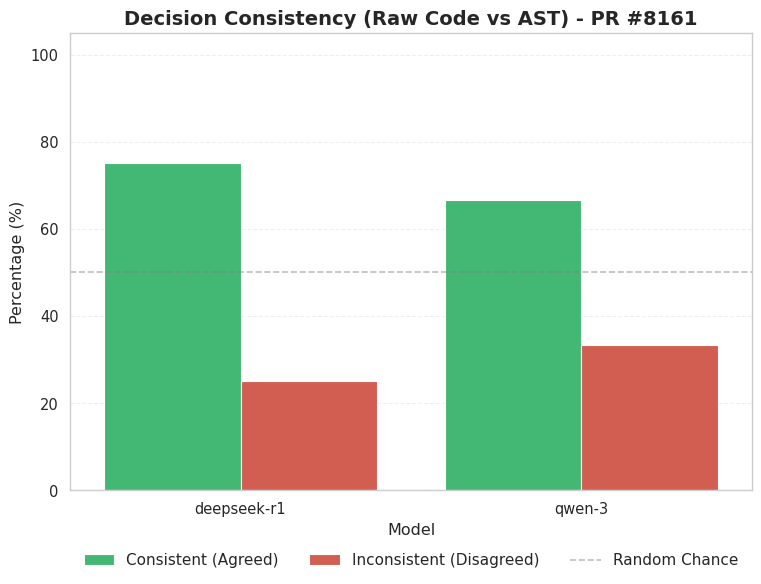


[PR #8587] Inconsistent decisions found:
  Model: qwen-3
    - Binary: task-readstat_sav_parse_date-O2.so (Code chose: PR | AST chose: BASE)
--------------------------------------------------


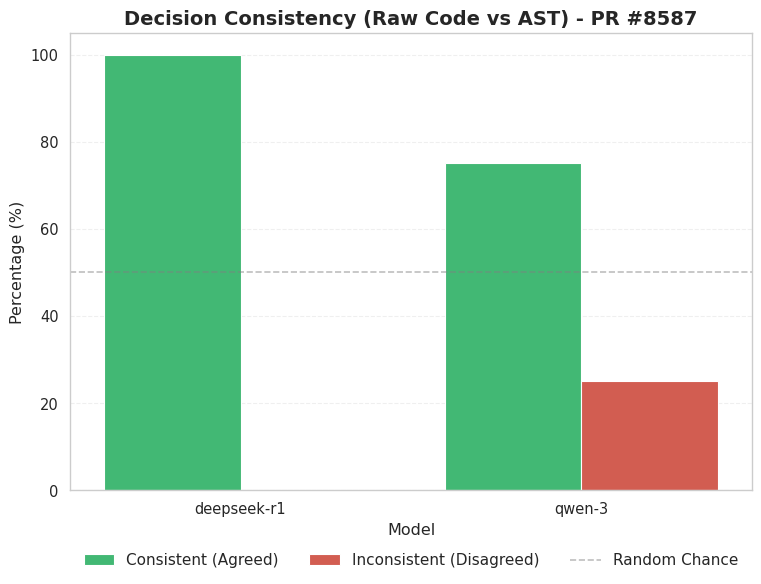


[PR #8628] Inconsistent decisions found:
  Model: qwen-3
    - Binary: task-readstat_sav_parse_date-O3.so (Code chose: PR | AST chose: BASE)
    - Binary: task-readstat_readstat_parse_por-O0.so (Code chose: BASE | AST chose: PR)
--------------------------------------------------


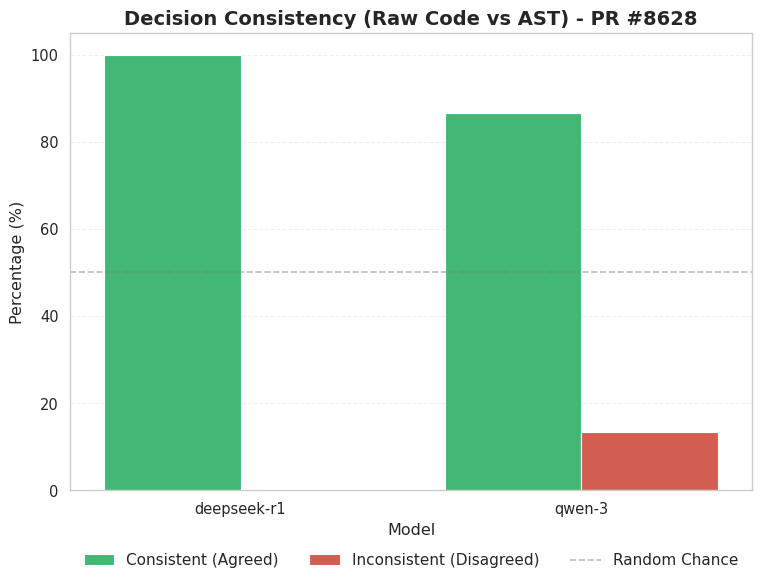

In [130]:
def plot_code_vs_ast_consistency(df):
    col_code = 'qualitative_winner'
    col_ast = 'qualitative_ast_winner'
    title = 'Decision Consistency (Raw Code vs AST)'
    
    unique_prs = sorted(df['pr'].dropna().unique())
    
    for pr_id in unique_prs:
        df_pr = df[df['pr'] == pr_id].copy()
        
        valid_outcomes = ['BASE', 'PR']
        
        df_valid = df_pr[
            (df_pr[col_code].isin(valid_outcomes)) & 
            (df_pr[col_ast].isin(valid_outcomes))
        ].copy()
        
        if df_valid.empty:
            print(f"PR #{pr_id}: Not enough decisive data (Too many TIEs/Errors)")
            continue
            
        df_valid['outcome'] = np.where(
            df_valid[col_code] == df_valid[col_ast], 
            'Consistent (Agreed)', 
            'Inconsistent (Disagreed)'
        )
        
        inconsistent_df = df_valid[df_valid['outcome'] == 'Inconsistent (Disagreed)']
        if not inconsistent_df.empty:
            print(f"\n[PR #{pr_id}] Inconsistent decisions found:")
        
            for model_name, group in inconsistent_df.groupby('model'):
                print(f"  Model: {model_name}")
                for _, row in group.iterrows():
                    print(f"    - Binary: {row['binary']} (Code chose: {row[col_code]} | AST chose: {row[col_ast]})")
            print("-" * 50)
        
        counts = df_valid.groupby(['model', 'outcome']).size().reset_index(name='count')
        total_per_model = counts.groupby('model')['count'].sum().reset_index(name='total')
        counts = counts.merge(total_per_model, on='model')
        
        counts['percentage'] = (counts['count'] / counts['total']) * 100
        
        fig, ax = plt.subplots(figsize=(8, 6))
        
        hue_order = ['Consistent (Agreed)', 'Inconsistent (Disagreed)']
        colors = {'Consistent (Agreed)': '#2ecc71', 'Inconsistent (Disagreed)': '#e74c3c'}

        sns.barplot(
            data=counts,
            x='model',
            y='percentage',
            hue='outcome',
            hue_order=hue_order,
            palette=colors,
            ax=ax
        )
        
        ax.set_title(f"{title} - PR #{pr_id}", fontsize=14, fontweight='bold')
        ax.set_ylabel('Percentage (%)')
        ax.set_xlabel('Model')
        ax.set_ylim(0, 105)
        
        ax.axhline(50, color='gray', linestyle='--', alpha=0.5, label='Random Chance')
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), 
                  ncol=3, fontsize=11, title_fontsize=12, frameon=False)
        
        plt.tight_layout()
        plt.show()

plot_code_vs_ast_consistency(df_reports)

In [131]:
if not df_reports.empty:
    print(f"=== Top 20 Functions with Highest Perplexity Change for Model: ===")
    unique_models = df_reports['model'].unique()
    types = ['ast_delta_ppl', 'delta_ppl']
    for t in types:
        print(f"\n- Metric: {t} ---")
        for model in unique_models:
            print(f"\n--- Model: {model} ---")
            df_model = df_reports[df_reports['model'] == model]
            df_model = df_model.assign(abs_delta=df_model[t].abs())
            #print(f"Total valid records for {model}: {len(df_model)}")
            
            top_changes = df_model.sort_values('abs_delta', ascending=False).head(20)

            #print(len(top_changes))
            
            cols = ['pr', 'binary', 'function', 'abs_delta', 'ast_delta_ppl', 'qualitative_winner', 'qualitative_ast_winner', 'qualitative_winner_s', 'qualitative_ast_winner_s']
            
            # Styling the table for readability
            styled_table = top_changes[cols].style.background_gradient(
                subset=['abs_delta'], cmap='Reds'
            ).format({'abs_delta': "{:.4f}"})
            
            display(styled_table)

=== Top 20 Functions with Highest Perplexity Change for Model: ===

- Metric: ast_delta_ppl ---

--- Model: qwen-3 ---



--- Model: deepseek-r1 ---



- Metric: delta_ppl ---

--- Model: qwen-3 ---



--- Model: deepseek-r1 ---


In [132]:
#print ast when winner is base or pr
for index, row in df_ast_valid.iterrows():
    if row['qualitative_ast_winner'].lower() in ['base', 'pr']:
        print(f"Model: {row['model']}, Function: {row['function']}, AST Winner: {row['qualitative_ast_winner']}, pr: {row['pr']}")
        print("----SOURCE AST-----")
        print(row.get('source_ast', 'N/A'))
        print("----- SOURCE CODE -----")
        print(row.get('source_code', 'N/A'))
        print("----- BASE AST -----")
        print(row.get('base_ast', 'N/A'))
        print("----- PR AST -----")
        print(row.get('pr_ast', 'N/A'))
        print("--------------------\n")

Model: qwen-3, Function: file_signextend, AST Winner: PR, pr: 7253
----SOURCE AST-----
type id(type *id, type *id, type id){
  if(!(id->id & id)){
    switch(id->id){
      case id:
        id = call(id, id, id);
        break;
      case id:
      case id:
      case id:
        id = call(id, id);
        break;
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
        id = call(id, id);
        break;
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
      case id:
        id = call(id, id);
        break;
      case id:
 

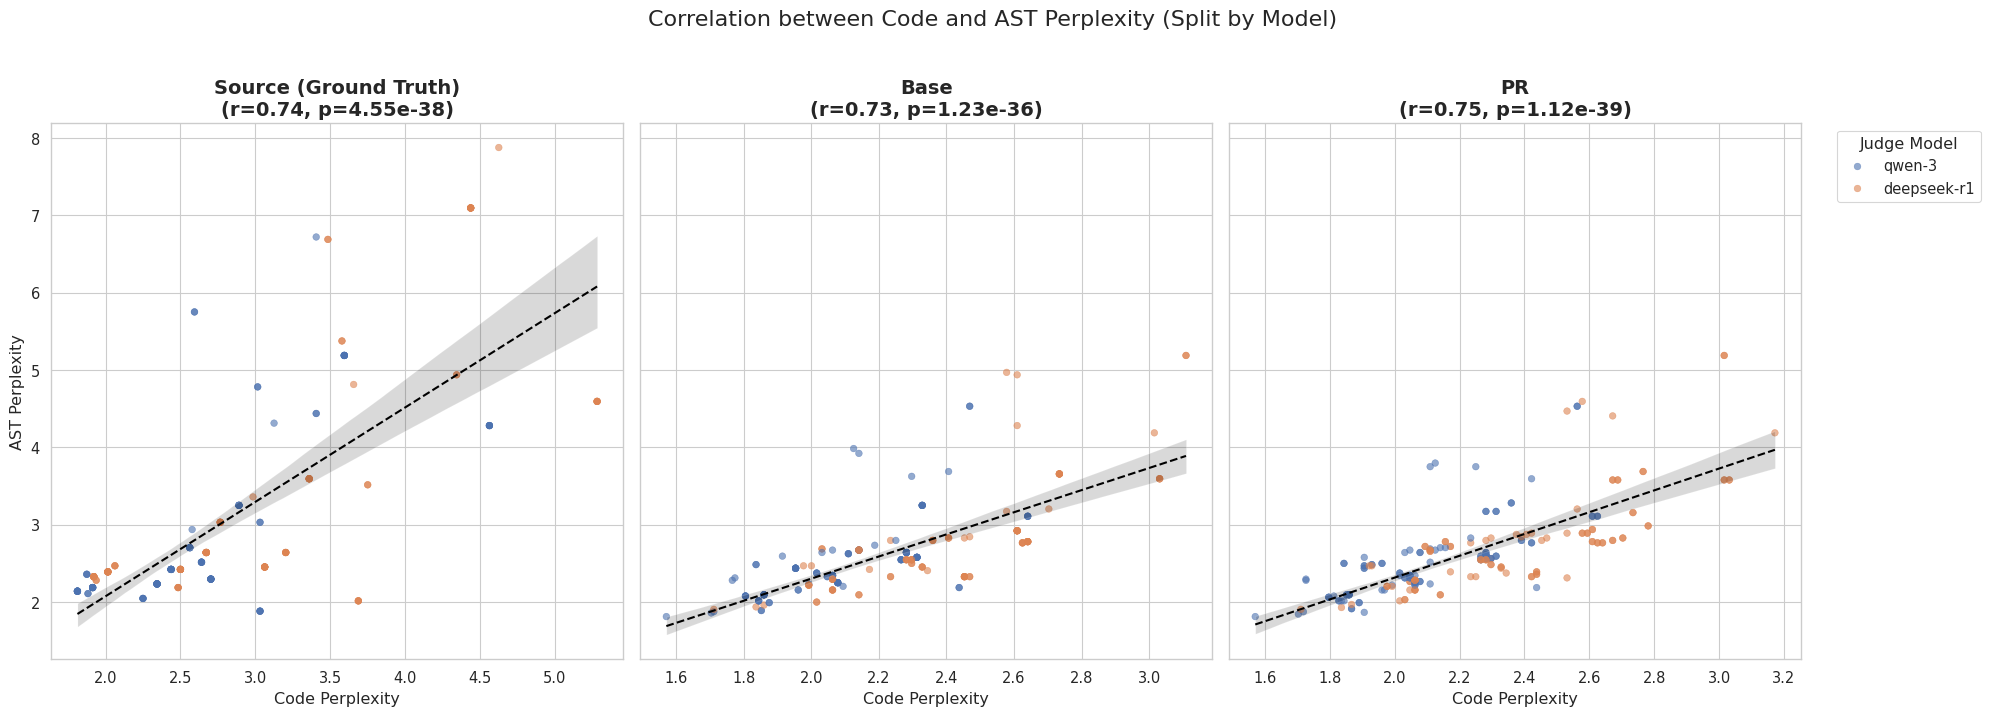

In [133]:
from scipy.stats import pearsonr

def plot_ppl_correlation_by_model(df):
    fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
    
    categories = [
        ('source_ppl', 'ast_source_ppl', 'Source (Ground Truth)'),
        ('base_ppl', 'ast_base_ppl', 'Base'),
        ('pr_ppl', 'ast_pr_ppl', 'PR')
    ]
    
    for i, (code_col, ast_col, label) in enumerate(categories):
        valid_data = df[[code_col, ast_col, 'model']].dropna()
        
        if len(valid_data) > 1:
            corr, p_value = pearsonr(valid_data[code_col], valid_data[ast_col])
            
            sns.scatterplot(
                data=valid_data, 
                x=code_col, 
                y=ast_col, 
                hue='model', 
                ax=axes[i],
                alpha=0.6,
                edgecolor=None
            )
            
            sns.regplot(
                data=valid_data, 
                x=code_col, 
                y=ast_col, 
                ax=axes[i],
                scatter=False, 
                color='black', 
                line_kws={'linestyle': '--', 'linewidth': 1.5, 'label': f'Global r={corr:.2f}'}
            )
            
            axes[i].set_title(f'{label}\n(r={corr:.2f}, p={p_value:.2e})', fontsize=14, fontweight='bold')
            axes[i].set_xlabel('Code Perplexity')
            axes[i].set_ylabel('AST Perplexity' if i == 0 else "")
            
            if i < 2:
                axes[i].get_legend().remove()
            else:
                axes[i].legend(title='Judge Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            axes[i].set_title(f'{label}: No Valid Data', fontsize=14, fontweight='bold')

    plt.suptitle('Correlation between Code and AST Perplexity (Split by Model)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_ppl_correlation_by_model(df_reports)

Found 2 models: ['deepseek-r1', 'qwen-3']

--- Processing Model: deepseek-r1 ---
Tokens: Src=157319, Dec=219952

--- Processing Model: qwen-3 ---
Tokens: Src=157319, Dec=219952


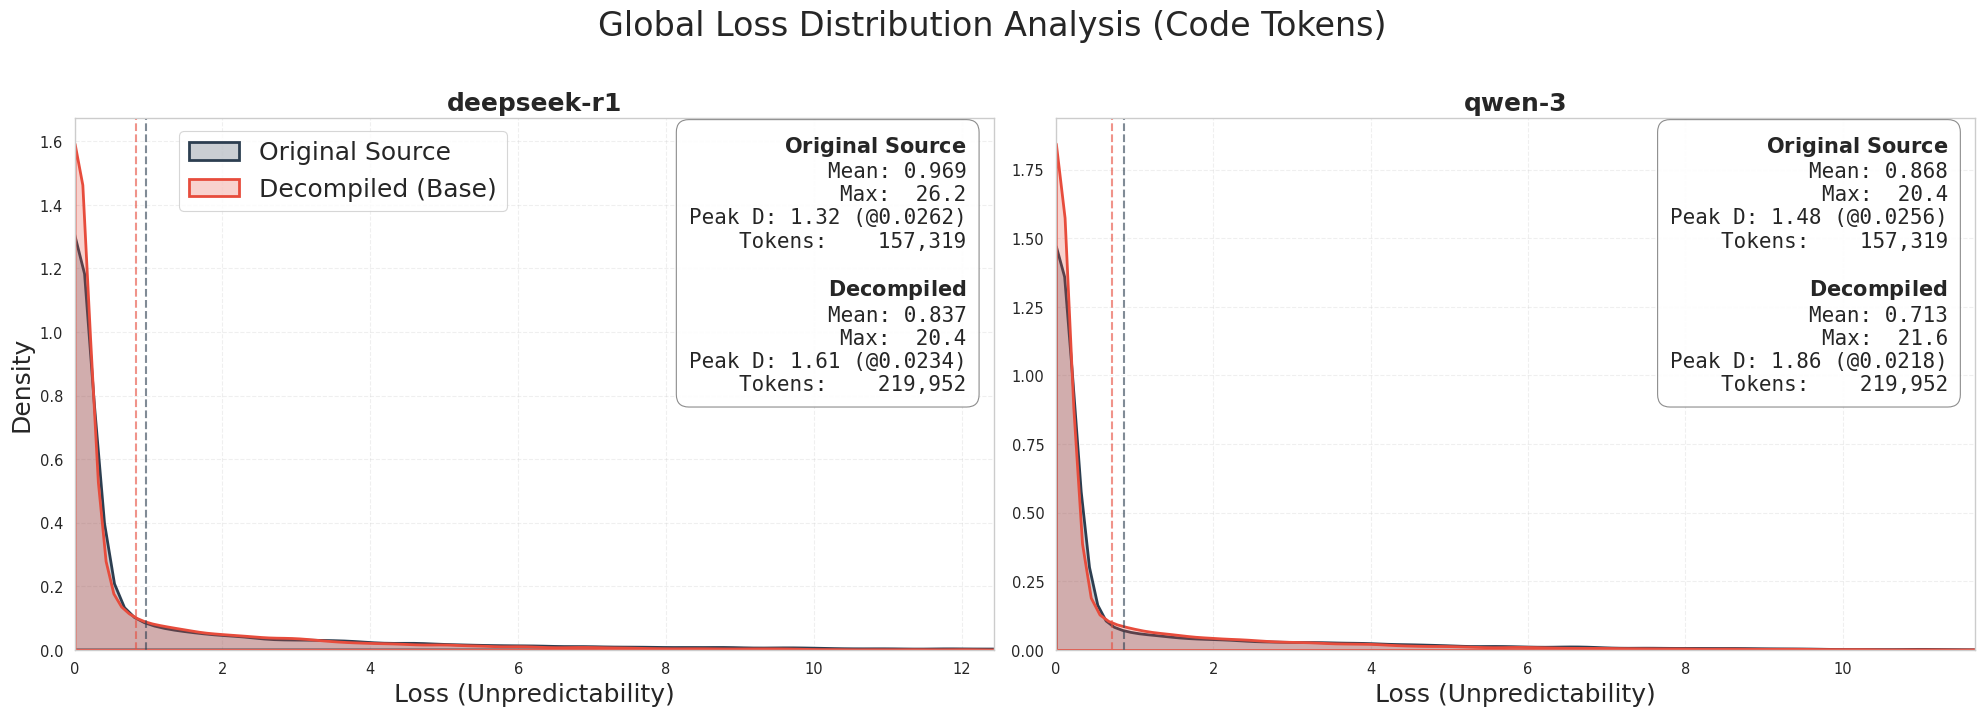

Found 2 models: ['deepseek-r1', 'qwen-3']

--- Processing Model: deepseek-r1 ---
Tokens: Src=92168, Dec=140440

--- Processing Model: qwen-3 ---
Tokens: Src=92168, Dec=140440


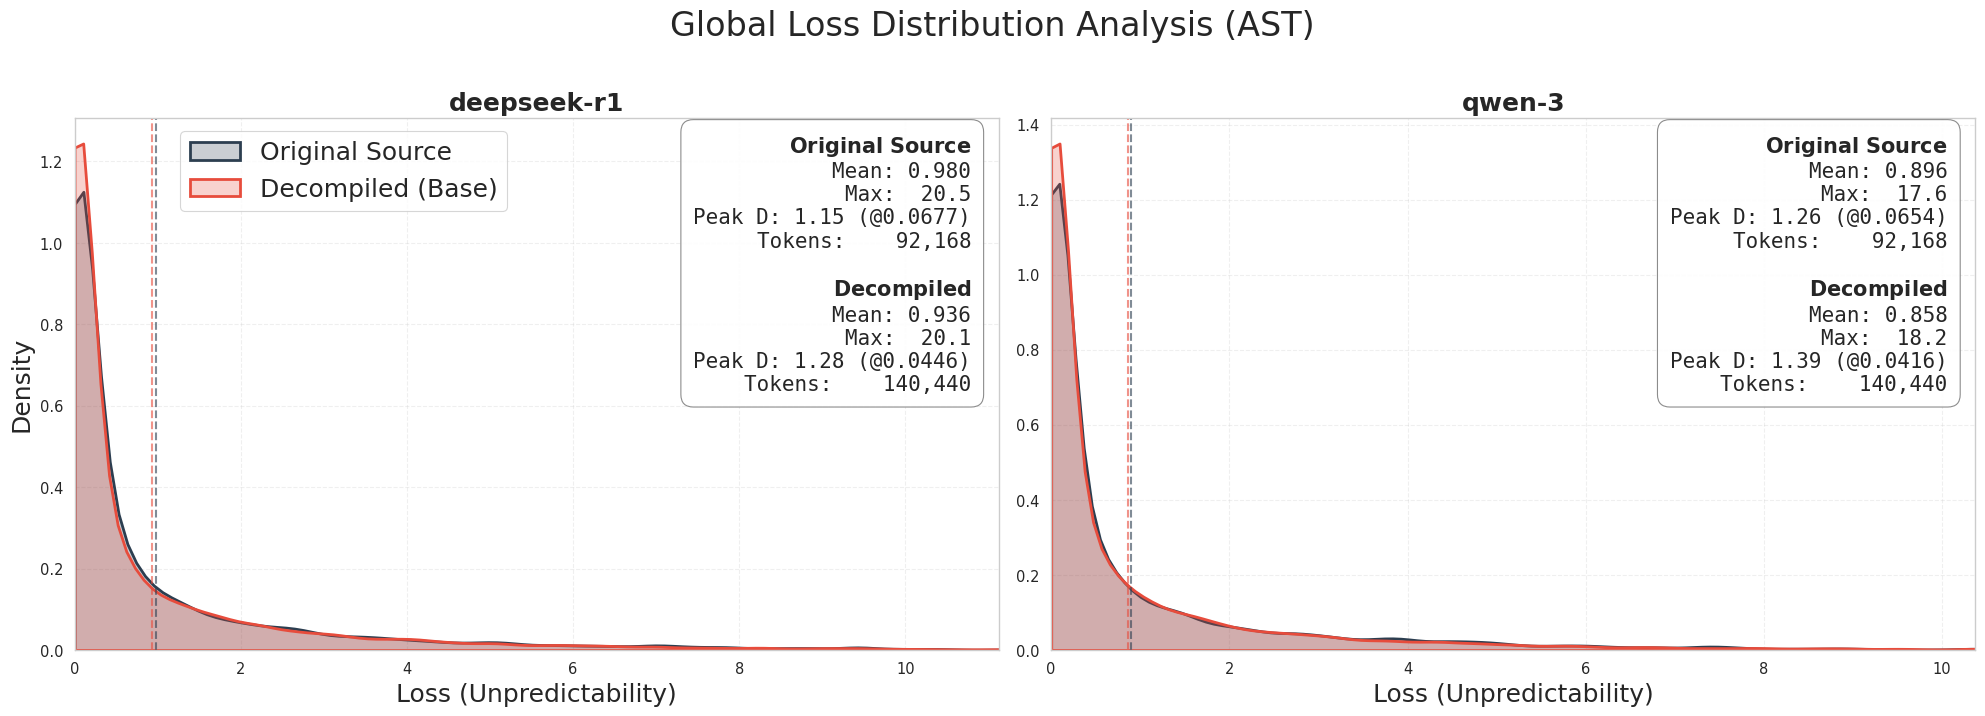

In [134]:


# def plot_single_function_loss(df, row_index=0, rolling_window=50):
#     try:
#         record = df.iloc[row_index]
#     except IndexError:
#         print("Index out of bounds.")
#         return

#     src_data = record.get('source_loss', {})
#     base_data = record.get('base_loss', {})
#     pr_data = record.get('pr_loss', {})

#     y_src = src_data.get('losses', [])
#     y_base = base_data.get('losses', [])
#     y_pr = pr_data.get('losses', [])

#     if not y_src or not y_base:
#         print(f"Data loss not available for row {row_index}")
#         return

#     model_name = record['model']
#     func_name = record.get('function', 'Unknown Function')
#     print(f"Analysis: {func_name} | Model: {model_name}")
#     print(f"Tokens Count -> Source: {len(y_src)}, Base: {len(y_base)}, PR: {len(y_pr)}")

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

#     #line plot
    
#     # Helper for moving average
#     def moving_average(data, window):
#         return pd.Series(data).rolling(window=window, min_periods=1).mean()

#     ax1.plot(moving_average(y_src, rolling_window), label=f'Source (Orig) - {len(y_src)} toks', color='black', alpha=0.7, linewidth=1.5)
#     ax1.plot(moving_average(y_base, rolling_window), label=f'Base (Decomp) - {len(y_base)} toks', color='red', alpha=0.6, linewidth=1)
#     # Opzionale: PR se diverso da Base
#     if len(y_pr) > 0:
#         ax1.plot(moving_average(y_pr, rolling_window), label=f'PR (Decomp) - {len(y_pr)} toks', color='green', alpha=0.6, linestyle='--', linewidth=1)

#     ax1.set_title(f'Token Loss Trajectory (Smoothed w/{rolling_window})', fontsize=14)
#     ax1.set_xlabel('Token Position (Sequence Index)')
#     ax1.set_ylabel('Cross Entropy Loss')
#     ax1.legend()

#     #hist plot
#     sns.kdeplot(y_src, fill=True, color='black', label='Source', ax=ax2, bw_adjust=0.5)
#     sns.kdeplot(y_base, fill=True, color='red', label='Base', ax=ax2, bw_adjust=0.5)
#     if len(y_pr) > 0:
#         sns.kdeplot(y_pr, fill=True, color='green', label='PR', linestyle='--', ax=ax2, bw_adjust=0.5)

#     ax2.set_title('Loss Distribution Density', fontsize=14)
#     ax2.set_xlabel('Loss Value')
#     ax2.set_ylabel('Density')
#     ax2.set_xlim(0, 10)
#     ax2.legend()

#     plt.suptitle(f"Loss Analysis: {func_name} (PR #{record['pr']})", fontsize=16)
#     plt.tight_layout()
#     plt.show()


def plot_loss_distribution_by_model(df, isast=False):
    
    unique_models = sorted(df['model'].unique())
    n_models = len(unique_models)
    print(f"Found {n_models} models: {unique_models}")
    
    if n_models == 0:
        print("No models found.")
        return

    fig, axes = plt.subplots(1, n_models, figsize=(10 * n_models, 7))
    
    if n_models == 1:
        axes = [axes]

    def get_kde_stats(data):
        if len(data) == 0: return 0, 0, 0, 0
        mean_val = np.mean(data)
        max_val = np.max(data)
        try:
            kde = stats.gaussian_kde(data)
            x_grid = np.linspace(0, np.percentile(data, 99.5), 500) 
            y_grid = kde(x_grid)
            peak_density = np.max(y_grid)
            peak_loc = x_grid[np.argmax(y_grid)]
        except Exception:
            peak_density, peak_loc = 0, 0
        return mean_val, max_val, peak_density, peak_loc

    for ax, model_id in zip(axes, unique_models):
        print(f"\n--- Processing Model: {model_id} ---")
    
        df_model = df[df['model'] == model_id]
        all_src_losses = []
        all_base_losses = []
        

        for _, row in df_model.iterrows():
            src_key = 'source_ast_loss' if isast else 'source_loss'
            src_data = row.get(src_key, {})
            if isinstance(src_data, dict):
                s_vals = src_data.get('losses', [])
                if isinstance(s_vals, list): all_src_losses.extend(s_vals)
            
            # Base Key Selection (with fallback)
            base_key_p = 'base_ast_loss' if isast else 'function_base_loss'
            base_key_f = 'base_ast_loss' if isast else 'base_loss'
            base_data = row.get(base_key_p) if base_key_p in row else row.get(base_key_f, {})
            
            if isinstance(base_data, dict):
                b_vals = base_data.get('losses', [])
                if isinstance(b_vals, list): all_base_losses.extend(b_vals)

        if not all_src_losses or not all_base_losses:
            ax.text(0.5, 0.5, "No Data Available", ha='center', va='center')
            ax.set_title(model_id)
            continue

        print(f"Tokens: Src={len(all_src_losses)}, Dec={len(all_base_losses)}")

        combined_max = max(np.max(all_src_losses), np.max(all_base_losses))
        clip_val = combined_max * 1.2
        cutoff_x = np.percentile(all_src_losses + all_base_losses, 99.5) # Zoom sul 99.5% dei dati

        # --- PLOTTING ---
        sns.kdeplot(all_src_losses, fill=True, color='#2c3e50', label='Original Source', clip=(0, clip_val), ax=ax, linewidth=2)
        sns.kdeplot(all_base_losses, fill=True, color='#e74c3c', label='Decompiled (Base)', clip=(0, clip_val), ax=ax, linewidth=2)
        
        # Stats
        src_mean, src_max, src_peak_y, src_peak_x = get_kde_stats(all_src_losses)
        base_mean, base_max, base_peak_y, base_peak_x = get_kde_stats(all_base_losses)

        ax.axvline(src_mean, color='#2c3e50', linestyle='--', alpha=0.6, linewidth=1.5)
        ax.axvline(base_mean, color='#e74c3c', linestyle='--', alpha=0.6, linewidth=1.5)

        # Box Info
        stats_text = (
            r"$\bf{Original\ Source}$" + "\n"
            f"Mean: {src_mean:.3f}\n"
            f"Max:  {src_max:.1f}\n"
            f"Peak D: {src_peak_y:.2f} (@{src_peak_x:.4f})\n"
            f"Tokens:    {len(all_src_losses):,}\n"
            "\n"
            r"$\bf{Decompiled}$" + "\n"
            f"Mean: {base_mean:.3f}\n"
            f"Max:  {base_max:.1f}\n"
            f"Peak D: {base_peak_y:.2f} (@{base_peak_x:.4f})\n"
            f"Tokens:    {len(all_base_losses):,}"
        )

        props = dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9, edgecolor='gray')
        ax.text(0.97, 0.97, stats_text, transform=ax.transAxes, fontsize=15,
                verticalalignment='top', horizontalalignment='right', bbox=props, fontfamily='monospace')

        ax.set_title(f'{model_id}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Loss (Unpredictability)', fontsize=18)
        ax.set_xlim(0, cutoff_x)
        ax.grid(True, linestyle='--', alpha=0.3)
        
        if ax == axes[0]:
            ax.set_ylabel('Density', fontsize=18)
            ax.legend(loc='upper left', bbox_to_anchor=(0.1, 1.0), fontsize=18)
        else:
            ax.set_ylabel('') 
            ax.legend().remove() 

    plt.suptitle(f"Global Loss Distribution Analysis {'(AST)' if isast else '(Code Tokens)'}", fontsize=24, y=1.02)
    plt.tight_layout()
    plt.show()

# Specific case
# valid_idx = df_reports[df_reports['source_ppl'].notna()].index[0]
# plot_single_function_loss(df_reports, row_index=valid_idx, rolling_window=20)

# global overview
plot_loss_distribution_by_model(df_reports)
plot_loss_distribution_by_model(df_reports, isast=True)

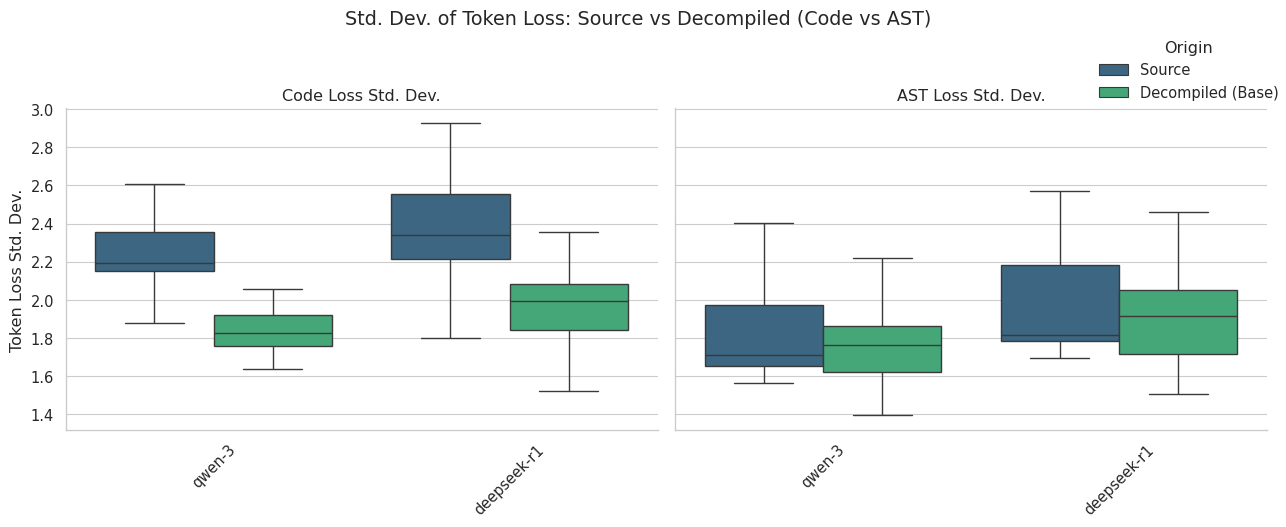

In [135]:
def loss_std(loss_obj):
    if isinstance(loss_obj, dict):
        vals = loss_obj.get("losses", [])
        if isinstance(vals, list) and len(vals) > 0:
            return float(np.std(vals, ddof=1)) if len(vals) > 1 else float(np.std(vals, ddof=0))
    return np.nan

df_std = df_reports.copy()
df_std["std_source"] = df_std["source_loss"].apply(loss_std)
df_std["std_base"] = df_std["base_loss"].apply(loss_std)
df_std["std_source_ast"] = df_std["source_ast_loss"].apply(loss_std)
df_std["std_base_ast"] = df_std["base_ast_loss"].apply(loss_std)

df_plot = pd.melt(
    df_std,
    id_vars=["model"],
    value_vars=["std_source", "std_base", "std_source_ast", "std_base_ast"],
    var_name="metric",
    value_name="loss_std"
)

df_plot["version"] = np.where(df_plot["metric"].str.contains("ast"), "AST", "Code")
df_plot["origin"] = df_plot["metric"].map({
    "std_source": "Source",
    "std_base": "Decompiled (Base)",
    "std_source_ast": "Source",
    "std_base_ast": "Decompiled (Base)"
})

df_plot = df_plot.dropna(subset=["loss_std"])

g = sns.catplot(
    data=df_plot,
    x="model",
    y="loss_std",
    hue="origin",
    col="version",
    kind="box",
    palette="viridis",
    showfliers=False,
    height=5,
    aspect=1.1
)
g.set_axis_labels("", "Token Loss Std. Dev.")
g.set_titles("{col_name} Loss Std. Dev.")
g.set_xticklabels(rotation=45)
g._legend.set_title("Origin") 
g._legend.set_bbox_to_anchor((1, 1))
g._legend.set_loc("upper right")
plt.suptitle("Std. Dev. of Token Loss: Source vs Decompiled (Code vs AST)", y=1.05)
plt.tight_layout()
plt.show()

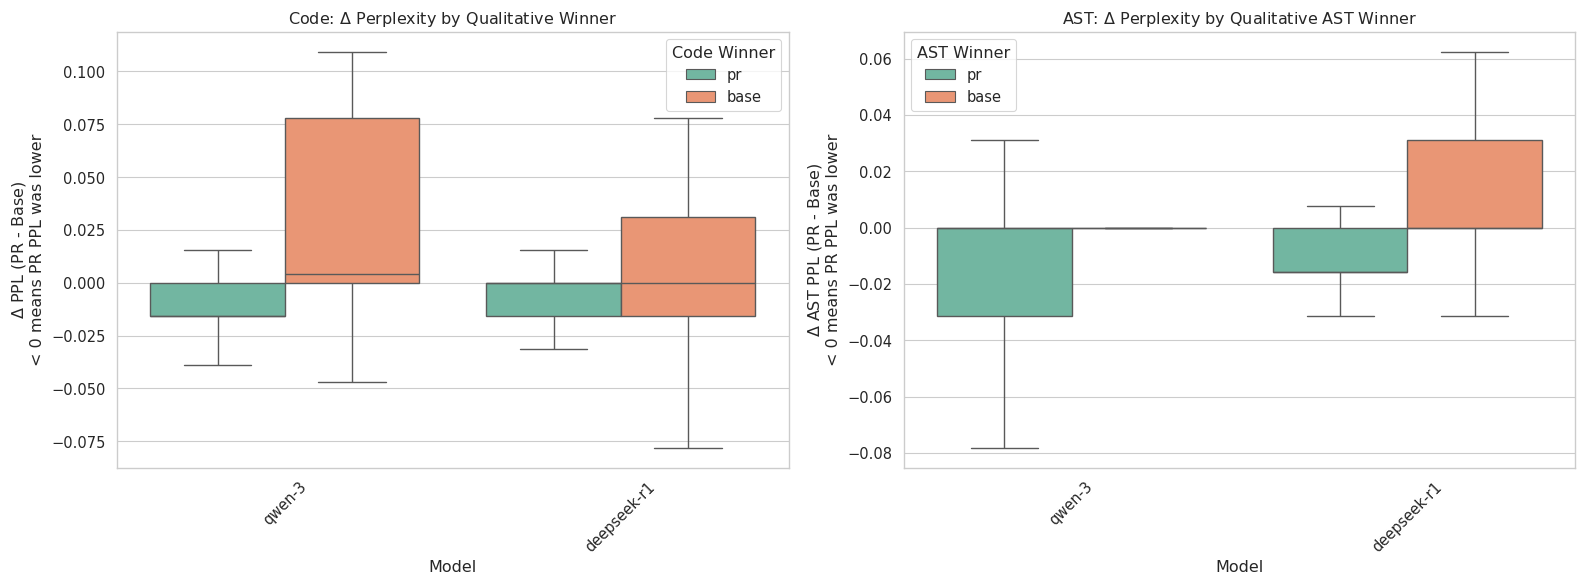


--- Correlation Results (Point-Biserial) ---
Note: A negative correlation (r) indicates that when PR wins (Winner=1),
the Delta PPL is negative (meaning PR had LOWER/BETTER perplexity).


Model  Code Corr (r)  Code p-value  Code N  AST Corr (r)  \
0       qwen-3        -0.0833        0.5232      61       -0.1825   
1  deepseek-r1        -0.0625        0.5970      74       -0.1329   

   AST p-value  AST N  
0       0.1147     76  
1       0.2399     80

         Model  Code Corr (r)  Code p-value  Code N  AST Corr (r)  \
0       qwen-3        -0.0833        0.5232      61       -0.1825   
1  deepseek-r1        -0.0625        0.5970      74       -0.1329   

   AST p-value  AST N  
0       0.1147     76  
1       0.2399     80  


In [ ]:
def evaluate_ppl_correlations(df):
    df_corr = df.copy()
    
    df_corr['qual_winner_clean'] = df_corr['qualitative_winner'].astype(str).str.lower().str.strip()
    df_corr['ast_winner_clean'] = df_corr['qualitative_ast_winner'].astype(str).str.lower().str.strip()
    
    
    def binarize_winner(winner):
        if winner in ['pr', 'function_pr']: return 1
        elif winner in ['base', 'function_base']: return 0
        return np.nan
    
    df_corr['code_winner_bin'] = df_corr['qual_winner_clean'].apply(binarize_winner)
    df_corr['ast_winner_bin'] = df_corr['ast_winner_clean'].apply(binarize_winner)
    
    df_code = df_corr.dropna(subset=['delta_ppl', 'code_winner_bin']).copy()
    df_ast = df_corr.dropna(subset=['ast_delta_ppl', 'ast_winner_bin']).copy()
    
    results = []
    
    for model in df_corr['model'].dropna().unique():
        model_code = df_code[df_code['model'] == model]
        if len(model_code) > 2:
            r_code, p_code = stats.pointbiserialr(model_code['code_winner_bin'], model_code['delta_ppl'])
        else:
            r_code, p_code = np.nan, np.nan
            
        model_ast = df_ast[df_ast['model'] == model]
        if len(model_ast) > 2:
            r_ast, p_ast = stats.pointbiserialr(model_ast['ast_winner_bin'], model_ast['ast_delta_ppl'])
        else:
            r_ast, p_ast = np.nan, np.nan
            
        results.append({
            'Model': model,
            'Code Corr (r)': r_code,
            'Code p-value': p_code,
            'Code N': len(model_code),
            'AST Corr (r)': r_ast,
            'AST p-value': p_ast,
            'AST N': len(model_ast)
        })
        
    df_results = pd.DataFrame(results).round(4)
    
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Code Plot
    sns.boxplot(
        data=df_code, x='model', y='delta_ppl', hue='qual_winner_clean', 
        ax=axes[0], palette="Set2", showfliers=False
    )
    axes[0].set_title('Code: $\Delta$ Perplexity by Qualitative Winner')
    axes[0].set_ylabel('$\Delta$ PPL (PR - Base)\n< 0 means PR PPL was lower')
    axes[0].set_xlabel('Model')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Code Winner')
    
    # AST Plot
    sns.boxplot(
        data=df_ast, x='model', y='ast_delta_ppl', hue='ast_winner_clean', 
        ax=axes[1], palette="Set2", showfliers=False
    )
    axes[1].set_title('AST: $\Delta$ Perplexity by Qualitative AST Winner')
    axes[1].set_ylabel('$\Delta$ AST PPL (PR - Base)\n< 0 means PR PPL was lower')
    axes[1].set_xlabel('Model')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title='AST Winner')
    
    plt.tight_layout()
    plt.show()
    
    return df_results, df_code, df_ast

corr_table, valid_code_df, valid_ast_df = evaluate_ppl_correlations(df_reports)

print("\n--- Correlation Results (Point-Biserial) ---")
print("Note: A negative correlation (r) indicates that when PR wins (Winner=1),")
print("the Delta PPL is negative (meaning PR had LOWER/BETTER perplexity).")
display(corr_table)
print(corr_table)

In [ ]:
df_qwen = df_reports[df_reports['model'].str.contains('qwen-3', case=False, na=False)]

print("--- Qwen-3 Qualitative AST Winners ---")
print(df_qwen['qualitative_ast_winner'].value_counts(dropna=False))

print("\n--- Qwen-3 AST Perplexity Stats ---")
print(df_qwen[['ast_base_ppl', 'ast_pr_ppl', 'ast_delta_ppl']].describe())

--- Qwen-3 Qualitative AST Winners ---
qualitative_ast_winner
BASE     45
PR       31
TIE      30
Error     1
Name: count, dtype: int64

--- Qwen-3 AST Perplexity Stats ---
       ast_base_ppl  ast_pr_ppl  ast_delta_ppl
count    107.000000  107.000000     107.000000
mean       2.524679    2.522999      -0.001679
std        0.508277    0.502324       0.064128
min        1.812500    1.812500      -0.320312
25%        2.195312    2.203125      -0.015625
50%        2.437500    2.468750       0.000000
75%        2.640625    2.640625       0.015625
max        4.531250    4.531250       0.187500
